## Libraries

In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx
import re
import itertools
#from geopy import distance
from math import radians, degrees, sin, cos, asin, acos, sqrt, floor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


At each step (i.e. with the creation of each unimodal network), need to keep track of two things: <br>
1. link IDs for each link
1. the network topology, so which two nodes are connected by the link ID

In [2]:
string = 'bs1'
re.sub('\D', '', string)

'1'

## Helper functions

In [3]:
# nodes_type_list is list of tuples of form [(nodes_df, node_color, node_label)]
def plot_nodes_and_edges(node_type_list, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1, label='edges')
    for n in node_type_list:
        n[0].plot(ax=ax, color = n[1], label = n[2], zorder=2)
    ax.legend()
    return ax

In [4]:
# add a column for the node's position in the form used by networkx. 
# note: this is only useful when converting from geopandas df to networkx graph
def nx_pos(x, y):
    return {'pos': (x,y)}

In [5]:
# convert from gpd df to networkx graph object
# input: df of nodes
# output: networkx graph with nodes and positions. note: edges still need to be added to complete the graph structure
def to_nx_graph(nodes_df):
    graph_nodes = list(zip(nodes_df.ID.tolist(), nodes_df.nx_pos.tolist()))
    G = nx.DiGraph()
    G.add_nodes_from(graph_nodes)
    return G

In [6]:
# prune the edges of the edge df
# eliminates edges that connect nodes which are not members of the graph
# return graph edges in the proper form, ready to be added to the networkx graph
def prune_edges(G, edges_df):
    edges_df_subset = edges_df[(edges_df['N1'].isin(G.nodes)) & (edges_df['N2'].isin(G.nodes))]
    graph_edges = list(zip(edges_df_subset['N1'].tolist(), edges_df_subset['N2'].tolist(),
                       edges_df_subset['attr'].tolist()))
    return graph_edges

In [7]:
def nx_edge_attr(linkID, speed):
    attr_dict = {'linkID': linkID, 'speed':speed}
    return attr_dict

In [8]:
def nx_edge_attr(attr_name, attr_var):
    return {attr_name: attr_var}

In [9]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [10]:
def rename_nodes(G, prefix):
    re.sub('\D', '', string)
    new_nodename = [prefix + re.sub('\D', '', str(i)) for i in G.nodes]
    namemap = dict(zip(G.nodes, new_nodename))
    G = nx.relabel_nodes(G, namemap, True)
    return G

In [11]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
# input: single point, multipoint (collection of many nodes)
# output: the node in multipoint that is nearest to the input single point
def near(input_point, base_nodes_df):
    multipoint = base_nodes_df.geometry.unary_union
    nn_geom = nearest_points(input_point, multipoint)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn_geom)  # nearest neighbor distance 
    # find the ID (w.r.t the base network) of the nearest neighbor 
    idx = base_nodes_df['geometry'] == nn_geom
    nn_ID = base_nodes_df[idx]['ID'].to_numpy()[0]
    return (nn_geom, nn_ID, dist)

In [12]:
def draw_graph(G, node_color, node_cmap, edge_color):
    # draw the graph in networkx
    node_coords = nx.get_node_attributes(G, 'pos')    
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G, pos=node_coords, with_labels=False, font_color='white',  font_weight = 'bold',
            node_size=60, node_color=node_color, edge_color=edge_color, arrowsize=16, ax=ax)
    # add legend for node color    
    inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
    for v in set(inv_node_cmap.keys()):
        ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'upper right')
    return ax

In [13]:
# returns the travel mode the corresponds to the node
def mode(node_name):
    mode_of_node = re.sub(r'[^a-zA-Z]', '', node_name)
    return mode_of_node
mode('bs1')

'bs'

In [14]:
# coordinate matrix for all nodes in supernetwork:
# 2 columns, where col 0 is x-coord, col 1 is y-coord
# the row number corresponds to the node ID number. can use the nid map to look up the node name that 
# corresponds to the node ID number
def get_coord_matrix(G, node_id_map):
    coord_matrix = np.empty([len(node_id_map), 2])  # initialize
    for i in range(coord_matrix.shape[0]):    # then fill
        id_name = node_id_map[i]    # map from i to node_id name
        coord_matrix[i,0] = nx.get_node_attributes(G, "pos")[id_name][0]   # fill with x-coordinate
        coord_matrix[i,1] = nx.get_node_attributes(G, "pos")[id_name][1]   # fill with y-coordinate
    return coord_matrix

In [15]:
# find the great circle distance between an input row (point) and a reference matrix (all other points)
# GCD: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97#:~:text=The%20Great%20Circle%20distance%20formula,that%20the%20Earth%20is%20spherical.
# inputs: row (coords of single point), matrix_ref (coordinate matrix for all points)
def calc_great_circle_dist(row, matrix_ref):
    longs = matrix_ref[:,0]
    lats = matrix_ref[:,1]
    row_rad = np.array(list(map(radians, row)))
    lon1, lat1 = row_rad[0], row_rad[1]
    longs_rad = np.array(list(map(radians, longs))).reshape(len(longs),1)
    lats_rad = np.array(list(map(radians, lats))).reshape(len(lats),1)
    longs_lat_rad = np.hstack((longs_rad, lats_rad))  # order is long, lat
    
    r = 3958.656  # earth's radius in miles
    
    # account for floating point arithmetic to ensure that there is not a math domain error with arccos
    gcd = r * np.arccos(np.minimum( (np.sin(lat1) * np.sin(longs_lat_rad[:,1]) \
                  + np.cos(lat1) * np.cos(longs_lat_rad[:,1]) * np.cos(lon1 - longs_lat_rad[:,0])), 1))
    return gcd

In [16]:
# inputs: node of interest, matrix of euclidean distances b/w all nodes, travel mode of interest, all nodes in the original graph (id+name)
# output: nodeID of the node in the component network of the travel mode of interest that is nearest to the input node of interest
def nn(i, dist_matrix, travel_mode, node_id_map):
    # subset the node_id_map for the nodes in the component network of the travel mode of interest
    nid_map_travel_mode = [key for key,val in node_id_map.items() if val.startswith(travel_mode)]   # this is a list of IDs
    # subset dist matrix for the nodes in the component network of the travel mode of interest
    dist_subset = dist_matrix[:, nid_map_travel_mode]
    # find the node in the component network of interest that is nearest to the input node of interest
    nn_dist = np.amin(dist_subset[i])
    nn_idx = np.argmin(dist_subset[i])
    # now map back to the original node ID
    original_nn_id = nid_map_travel_mode[nn_idx]
    original_nn_name = node_id_map[original_nn_id]
    return (original_nn_id, original_nn_name, nn_dist)

In [17]:
# random edge costs used for testing; see if the paths still adhere to mode change constraints 
# input: graph, number of time intervals to consider
# output: vector of costs, where cost[i] is the cost associated with time interval i
# *ensure that the costs adhere to FIFO; 
# *that is, ((cost of interval i+1) -  (cost of interval i)) >= -length_interval
def random_edge_costs(G, num_intervals, interval_length, costLB, costUB):
    for e in G.edges.keys():
        cost_vector = []
        for i in range(num_intervals):          
            #print(i)
            if i == 0:    
                ecost = np.random.uniform(costLB, costUB)
                #print(ecost)
                cost_vector.append(ecost)
                nx.set_edge_attributes(G, {e: {'cost'+str(i): ecost}})
               #print(cost_vector)
            else:
                while True:
                    ecost = np.random.uniform(costLB, costUB)  # generate a cost
                    #print(ecost)
                    if (ecost - cost_vector[i-1]) >= -interval_length:  # check the FIFO constraint
                        cost_vector.append(ecost)
                        nx.set_edge_attributes(G, {e: {'cost'+str(i): ecost}})
                        #print(cost_vector)
                        break  # if FIFO constraint is met, go to next interval. o/w, return to top of while loop and regenerate a cost 
    return G

In [18]:
# find total cost of shortest weighted path
# input: graph, edges of shortest path, attribute used as weight
# output: total cost of shortest path
def sp_total_cost(G, sp_edges, weight):
    total_cost = 0
    for e in sp_edges:
        total_cost += G.edges[e][weight]
    #print('Total cost of the shortest path from org to dst = ', round(total_cost,2))  
    return(total_cost)

## Pittsburgh Road Network Data

In [19]:
cwd = os.getcwd() 
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

In [20]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/SPC_GIS/')
new_dir
os.chdir(new_dir)

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/SPC_GIS/'

In [21]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [22]:
nodes = read_file("new_node.shp")  # shapefile from Qiling
edges = read_file("new_link.shp")  # shapefile from Qiling

In [23]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

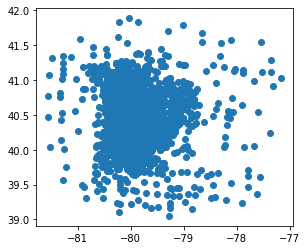

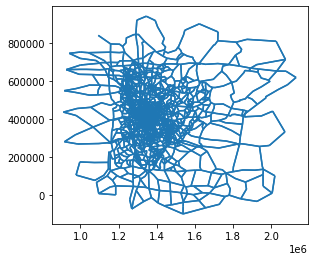

In [24]:
nodes.plot()
#nodes.crs
edges.plot()

## "Clip" the data: subset PGH road network by selected neighborhoods

In [25]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)

<AxesSubplot:>

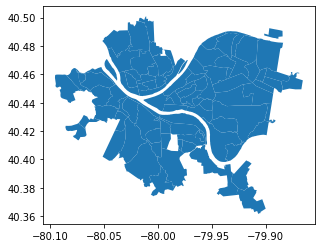

In [26]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [27]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
#hood_keep = [ 'Central Oakland', 'North Oakland', 'Squirrel Hill North', 'Squirrel Hill South', 'Shadyside']  # smaller list for testing
hood_keep = ['Squirrel Hill South', 'Squirrel Hill North']
# hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty', "Central Oakland", 'North Oakland', 
#              'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
#              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
#              'Glen Hazel', 'Swisshelm Park', 'Point Breeze'] 
             #'Upper Hill', 'Polish Hill', 'Lower Lawrenceville',
            #'Upper Lawrenceville'] #'Westwood', 'Crafton Heights', 'Sheraden', 'Windgap', 'Fairywood']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

In [28]:
# dissolve the neighborhoods together
pgh_nhoods_union = pgh_nhoods_mask.dissolve()
pgh_nhoods_union

,geometry,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,...,shape_ar_1,page_numbe,plannerass,created_us,created_da,last_edite,last_edi_1,temp,Shape__Are,Shape__Len
0,"POLYGON ((-79.91309 40.43804, -79.91300 40.438...",1337,203,42,003,140100,3,420031401003,Block Group 3,G5030,...,3.407871e+07,15,Ose Akinlotan,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,3.407739e+07,30347.886823


58

<AxesSubplot:>

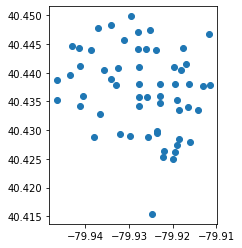

In [29]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

205

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
14934,1003206,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
3900,3206,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
1894,2746,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."
3902,3205,2047,998,25,1,0.03,0,3205+1002746,1363784.042,405223.271,1362556.958,405333.688,"LINESTRING (-79.92229 40.42530, -79.92392 40.4..."
4107,3201,2144,7787,25,1,0.01,0,3201,1364584.042,405521.882,1364430.917,405076.396,"LINESTRING (-79.91944 40.42617, -79.91995 40.4..."


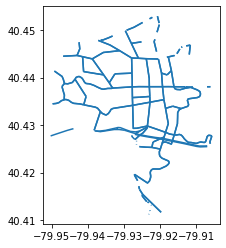

In [30]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

<AxesSubplot:>

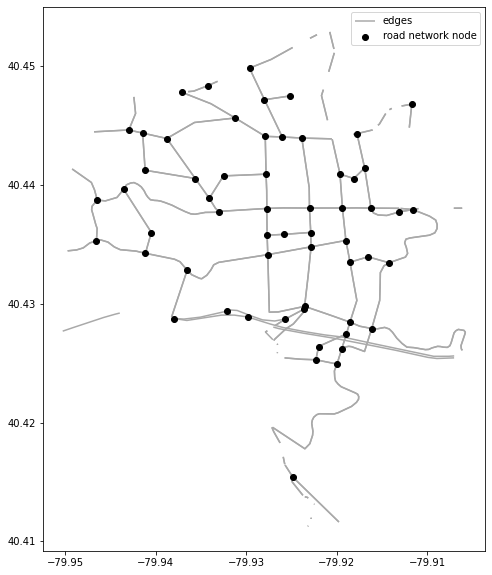

In [31]:
plot_nodes_and_edges([(nodes_clip, 'black', 'road network node')], edges_clip)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92486 40.45158, -79.92723 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92293 40.45236, -79.92217 40.4..."


<AxesSubplot:>

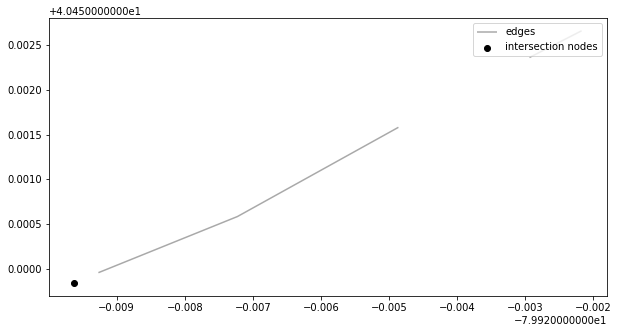

In [32]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32', 'linkID':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

plot_nodes_and_edges([(nclip_test, 'black', 'intersection nodes')], eclip_test)
# this plot confirms that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [33]:
#nodes_clip.loc[27]['geometry'].x
#nodes_clip.loc[27]['geometry'].y

In [34]:
edges_clip.head(3)
# redefine the linkIDs such that they correspond to the row number. not sure if this will mess things up yet
edges_clip.reset_index(inplace=True)
edges_clip['linkID'] = edges_clip.index
edges_clip.head()

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
14934,1003206,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
3900,3206,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
1894,2746,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."


,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,14934,0,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
1,3900,1,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
2,1894,2,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."
3,3902,3,2047,998,25,1,0.03,0,3205+1002746,1363784.042,405223.271,1362556.958,405333.688,"LINESTRING (-79.92229 40.42530, -79.92392 40.4..."
4,4107,4,2144,7787,25,1,0.01,0,3201,1364584.042,405521.882,1364430.917,405076.396,"LINESTRING (-79.91944 40.42617, -79.91995 40.4..."


## Convert geopandas df to networkx graph
### Because the small network test code was written using the networkx graph object

In [35]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry'], dtype='object')

In [36]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
nodes_clip.columns

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_pos'], dtype='object')

In [37]:
nodes_clip.head(3)

,ID,isOD,geometry,x,y,nx_pos
1657,2338,0,POINT (-79.92483 40.41541),-79.924826,40.415406,"{'pos': (-79.924826, 40.415406)}"
5570,7787,0,POINT (-79.91995 40.42493),-79.919949,40.424930,"{'pos': (-79.919949, 40.42493)}"
1447,2047,0,POINT (-79.92229 40.42529),-79.922285,40.425289,"{'pos': (-79.922285, 40.425289)}"


In [38]:
# add nodes to the graph, including their positions 
G_base = to_nx_graph(nodes_clip)
#G_base.nodes[37]['pos']

In [39]:
edges_clip['attr'] = edges_clip.apply(lambda e: nx_edge_attr('speed', e['spd']), axis=1)
#edges_clip['nx_linkID'] = edges_clip.apply(lambda e: nx_edge_attr('link_ID', e['linkID']), axis=1)
#edges_clip['attr'] = edges_clip.apply(lambda e: merge(e['nx_speed'], e['nx_linkID']), axis=1)
edges_clip.head(2)

,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,14934,0,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4...",{'speed': '25'}
1,3900,1,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4...",{'speed': '25'}


In [40]:
# only include edges if the nodes they connect are also in the nodes of the graph
graph_edges = prune_edges(G_base, edges_clip)
graph_edges[:3]

[(7787, 2047, {'speed': '25'}),
 (2047, 7787, {'speed': '25'}),
 (2144, 7787, {'speed': '25'})]

In [41]:
# add edges to the graph, including their speed limit
G_base.add_edges_from(graph_edges)
len(G_base.nodes)

58

Text(0.5, 1.0, 'Base Road Map for Selected Neighborhoods')

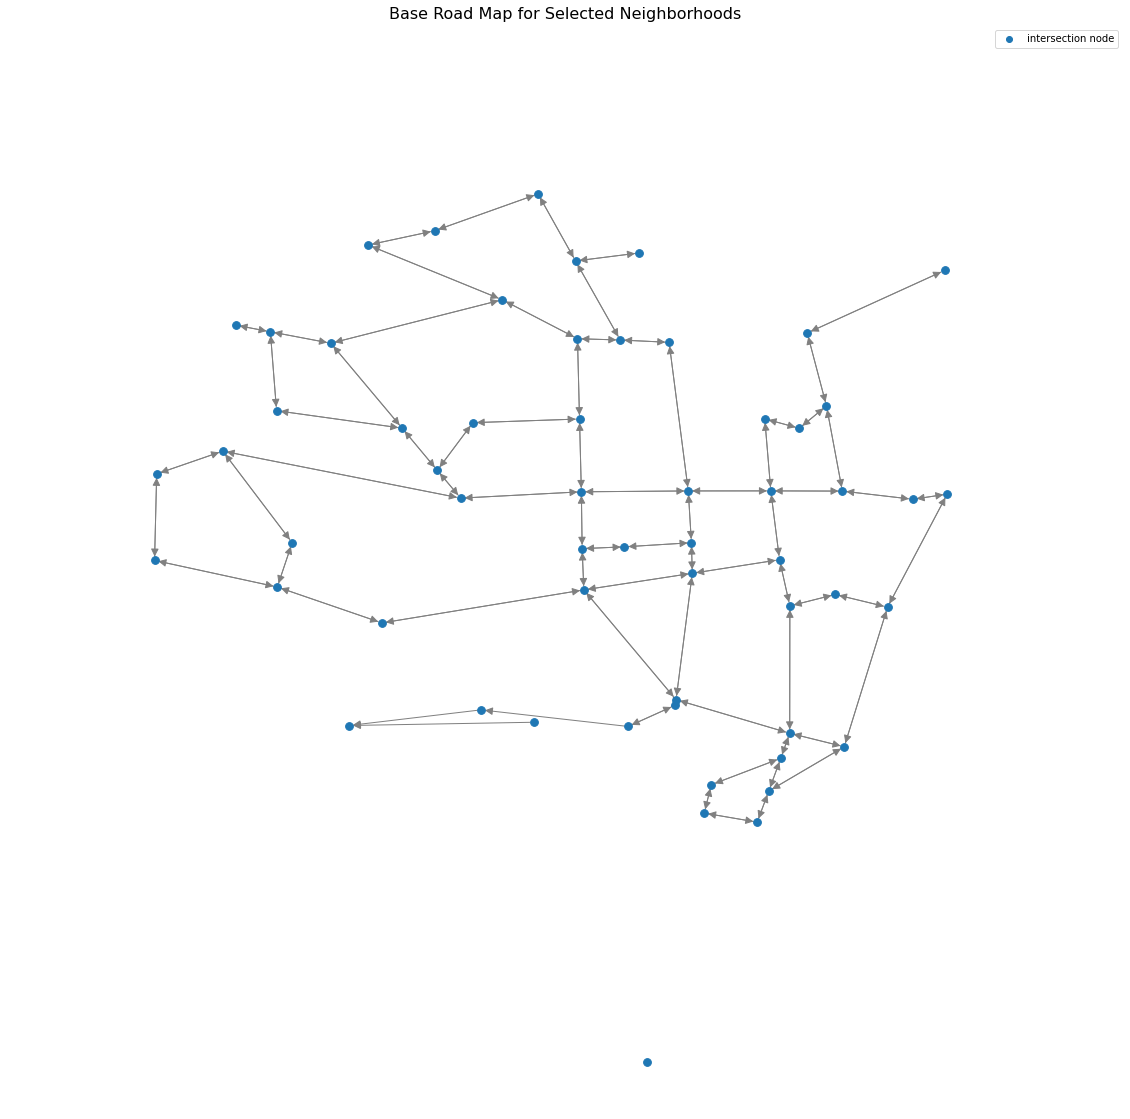

In [42]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_base, '#1f77b4', node_cmap, edge_color='gray')
ax.set_title('Base Road Map for Selected Neighborhoods', fontsize=16)

## TNC
The TNC graph is assumed to be the same as the base road network

In [43]:
G_tnc = G_base.copy()
G_tnc = rename_nodes(G_tnc, 't')

In [44]:
def set_link_IDs(G, prev_max_linkID):
    num_links = G.size()
    linkIDs = [i for i in range(prev_max_linkID+1, prev_max_linkID+1 + num_links)]
    a = dict(zip(G.edges, linkIDs))
    attr = {key: {'link_ID':val} for key, val in a.items()}
    nx.set_edge_attributes(G, attr)  

In [45]:
set_link_IDs(G_tnc, -1)
#test = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
#test

In [46]:
#G_tnc['t5188']['t903']

## Personal Vehicle 

### Park and Ride Data

In [47]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/ParkRide')
os.chdir(new_dir)
file_name = 'SPCRegPNR.shp'   # https://data.wprdc.org/dataset/regional-park-n-ride-facilities-web-inventory/resource/46692b9c-ad3f-4a29-8deb-5ca4207eb50d
pnr_gdf = read_file(file_name)
pnr_gdf.head(2)
#pnr_gdf.crs
# Transform geometry of edges to the proper coord system
pnr_gdf = pnr_gdf.to_crs(epsg = 4326)
#pnr_gdf.crs

,ID,STATUS,NAME,LOCATION,MUNIC,ZIPCITY,ZIPCODE,COUNTY,X_COORD,Y_COORD,RESTRICT_,CAPACITY,OWNER,PARK_FEE,D_PARK_FEE,M_PARK_FEE,SERV_TRANS,TRANS_OP_1,TRANS_OP_2,geometry
0,1.0,OPEN,OLYMPIA SHOPPING CENTER-WALNUT ST-MCKEESPORT,4313 WALNUT ST.,CITY OF MCKEESPORT,MCKEESPORT,15132,ALLEGHENY,40.32270,-79.83461,TRANSIT ONLY,50,PRIVATE,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1387303.979 367272.753)
1,2.0,OPEN,DUQUESNE-LIBRARY PL AT DUQUESNE BLVD-DUQUESNE,RT 837 (DUQUESNE BLVD.) AT LIBRARY PL.,CITY OF DUQUESNE,DUQUESNE,15110,ALLEGHENY,40.37227,-79.84466,NONE,311,PORT AUTHORITY OF ALLEGHENY COUNTY,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1384930.811 385392.023)


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

(0, 20)

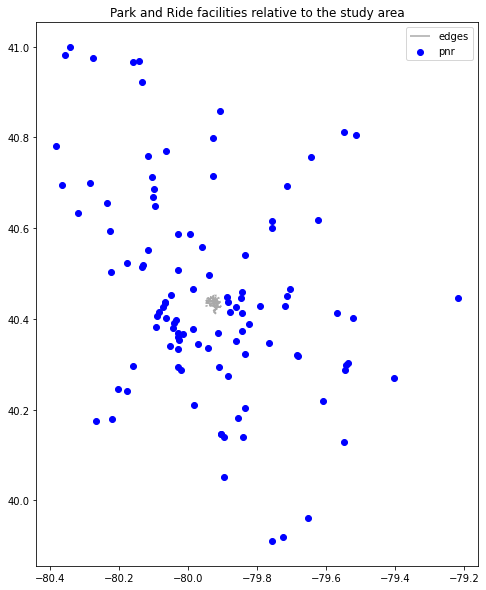

In [48]:
ax = plot_nodes_and_edges([(pnr_gdf, 'blue', 'pnr')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
# observe that no park and ride facilities intersect the study area...
# confirmation:
pnr_clip = gpd.clip(pnr_gdf, pgh_nhoods_mask)
pnr_clip.shape

Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

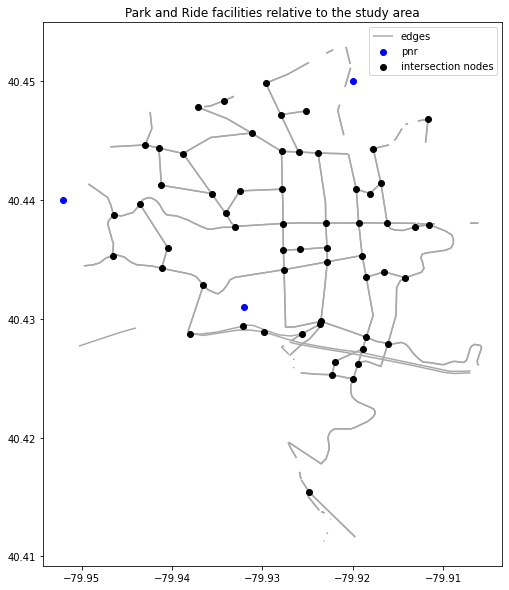

In [49]:
# for testing, i have chosen to create three fake pnr facilities located within study area
# randomly choose three nodes that are spread out in the road network
pnr1 = (-79.952, 40.44)
pnr2 = (-79.92, 40.45)
pnr3 = (-79.932, 40.431)
pnr_coords = [pnr1, pnr2, pnr3]
# build shapely Points from these coords
point_list = [Point(c[0], c[1]) for c in pnr_coords]
new_pnr_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(point_list), crs='EPSG:4326')
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')

### Create edges from Park and Ride stations to nearest node neighbor in the road network

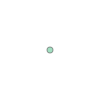

In [50]:
new_pnr_gdf['geometry'].iloc[0]

In [51]:
#from sklearn.neighbors import BallTree

In [52]:
a, b, c = near(new_pnr_gdf['geometry'][0], nodes_clip)
print(a,b,c)
new_pnr_gdf.head()
type(new_pnr_gdf)

POINT (-79.946459 40.438736) 1320 0.005683342062548135


,geometry
0,POINT (-79.95200 40.44000)
1,POINT (-79.92000 40.45000)
2,POINT (-79.93200 40.43100)


geopandas.geodataframe.GeoDataFrame

In [53]:
# find the intersection node in the road network that is nearest to the pnr station
new_pnr_gdf[['nn_geom','nn_ID','nn_dist']] = new_pnr_gdf.apply(lambda row: near(row['geometry'], nodes_clip), axis=1).tolist()
# add attributes necessary for conversion to nx.graph
new_pnr_gdf['x'] = new_pnr_gdf['geometry'].x
new_pnr_gdf['y'] = new_pnr_gdf['geometry'].y
new_pnr_gdf['nx_pos'] = new_pnr_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
new_pnr_gdf.insert(loc=0, column='ID', value=np.arange(len(new_pnr_gdf)))
new_pnr_gdf.head()
# add linestring beween each pnr facility and its nn (for graphing)
pnr_geom_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in new_pnr_gdf.iterrows()]
pnr_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(pnr_geom_edges), crs='EPSG:4326')
# these edges will be explicitly added to the networkx graph structure

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,ID,geometry,nn_geom,nn_ID,nn_dist,x,y,nx_pos
0,0,POINT (-79.95200 40.44000),POINT (-79.946459 40.438736),1320,0.005683,-79.952,40.440,"{'pos': (-79.952, 40.44)}"
1,1,POINT (-79.92000 40.45000),POINT (-79.925172 40.447496),6999,0.005746,-79.920,40.450,"{'pos': (-79.92, 40.45)}"
2,2,POINT (-79.93200 40.43100),POINT (-79.93214 40.429382),8286,0.001624,-79.932,40.431,"{'pos': (-79.932, 40.431)}"


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

<AxesSubplot:title={'center':'Park and Ride facilities relative to the study area'}>

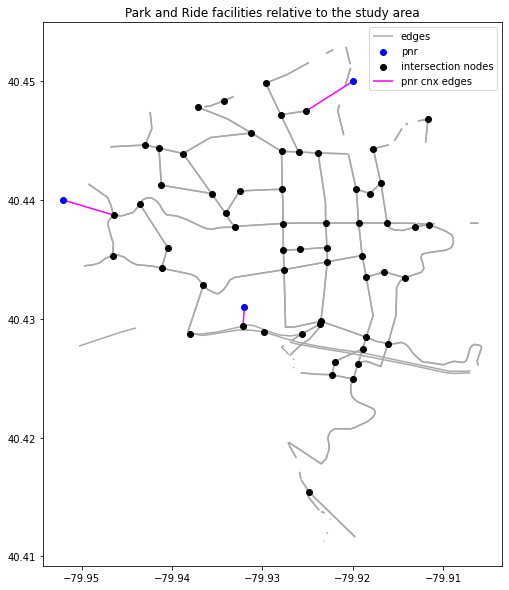

In [54]:
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
pnr_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='pnr cnx edges')
ax.legend()

### Convert to networkx graph object

In [55]:
# create graph structure 
# start with base road network
G_pv = G_base.copy()
G_pv = rename_nodes(G_pv, 'pv')

In [56]:
#G_pv.edges['pv5188', 'pv903']

In [57]:
# convert pnr nodes to nx graph and then merge with road network
G_pnr = to_nx_graph(new_pnr_gdf)
G_pnr = rename_nodes(G_pnr, 'k')
G_pv = nx.union_all([G_pv, G_pnr])   # merge the intersection nodes with the pnr stations

In [58]:
# add edges from pnr station to the road map in order to connect the network
new_pnr_gdf['nodeID'] = new_pnr_gdf.apply(lambda row: 'k'+str(row['ID']), axis=1)
new_pnr_gdf['nn_nodeID'] = new_pnr_gdf.apply(lambda row: 'pv'+str(row['nn_ID']), axis=1)
edges_out = list(zip(new_pnr_gdf['nodeID'], new_pnr_gdf['nn_nodeID']))
edges_in = list(zip(new_pnr_gdf['nn_nodeID'], new_pnr_gdf['nodeID']))
G_pv.add_edges_from(edges_out + edges_in)  

In [59]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_pv, prev_max_linkID)

142

Text(0.5, 1.0, 'Personal Vehicle Network')

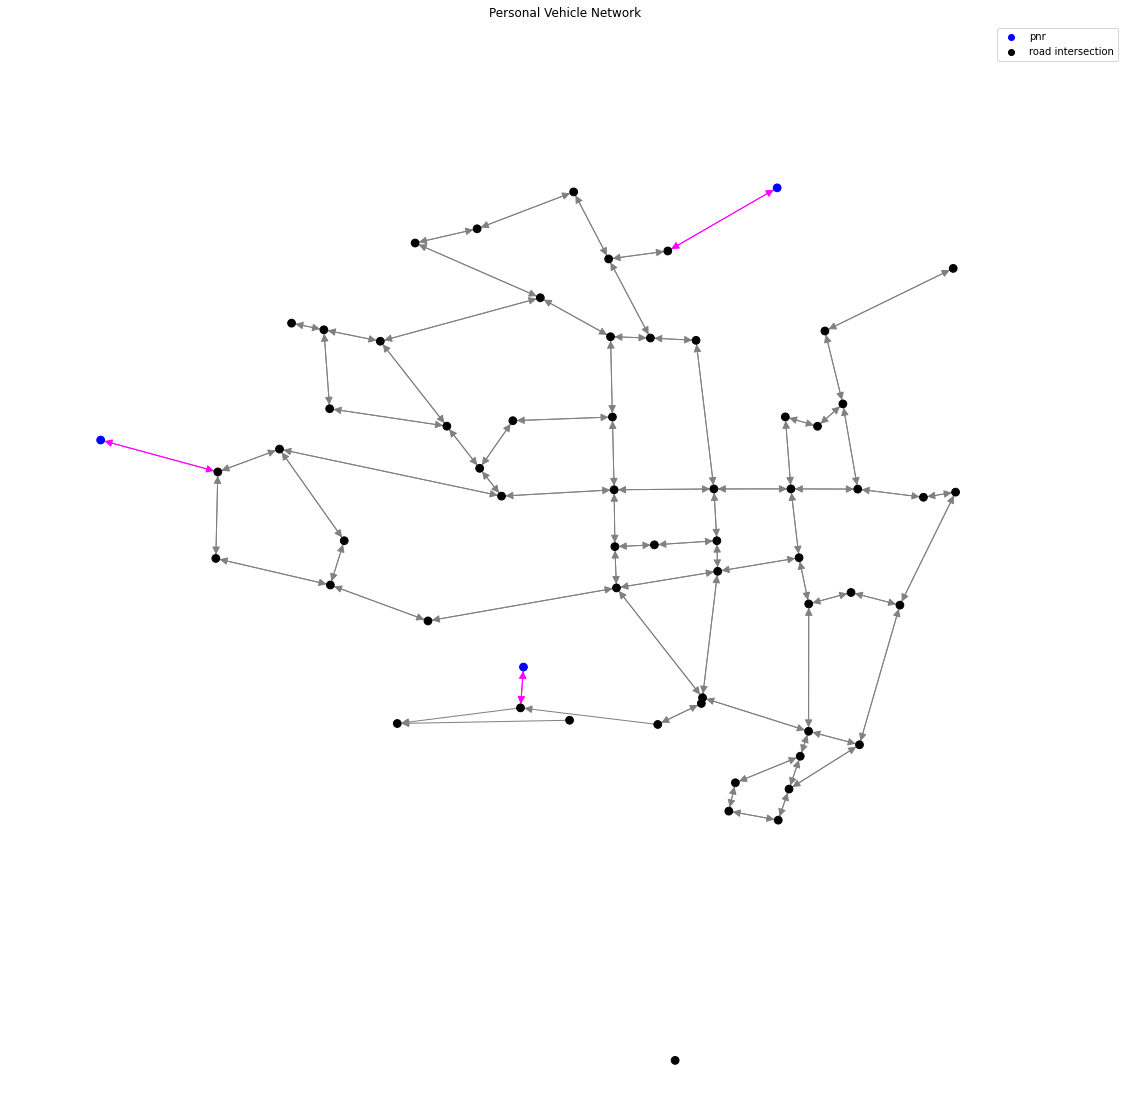

In [60]:
node_color = ['black' if n.startswith('pv') else 'blue' for n in G_pv.nodes]
edge_color = ['grey' if e[0].startswith('pv') and e[1].startswith('pv') else 'magenta' for e in G_pv.edges]
ax = draw_graph(G_pv, node_color, {'road intersection':'black', 'pnr':'blue'}, edge_color)
ax.set_title('Personal Vehicle Network')

**Summary up to this point** <br>
We began with the base road network node/link shapefile, which contained intersection nodes and road links. This was clipped to the study area of interest and converted into the networkx graph object after some data processing. The nodes have IDs and position attributes, and the links have IDs and speed limit attributes. The unimodal TNC network was taken to be an exact copy of the base road network. The personal vehicle network was then constructed as an exact copy of the base road network with two additions: 1) park + ride station nodes, and 2) park + ride connector edges. Connector edges are edges that join the station to the nearest road intersection node. It is necessary to construct these connector edges because the park and ride station nodes may not exactly intersect a road network node. It is also important to note that each unimodal network is associated with distinct node and link IDs; although the networks overlap in the physical world, they are considered unique in our model. Distinct node and link IDS are required to solve the multimodal shortest path problem.

## Personal Bike

In its simplest form, the personal bike network consists of the base road network, where only the street segments with a speed limit less than 40 mph (subject to change) are retained. We may also think about adding off-road bike paths. Furthermore, it will be useful to download the bike lane shapefile at some point, as this will be used to assess segment safety.

In [61]:
# Start with the original road network
# Then find the "bike-friendly" streets, i.e. those with a speed limit <= 40
bike_speedlim_max = 40
edges_clip['spd'] = edges_clip['spd'].astype('float')
bike_edges_clip = edges_clip[edges_clip['spd'] <= bike_speedlim_max]
edges_clip.shape
bike_edges_clip.shape  # only slight reduction in roads with a max speed limit of 40...could lower the max speed limit if desired
# Find the nodes that interesect the bike-friendly streets (in the clipped network)
nodes_keep = list(set(bike_edges_clip.N1.tolist() + bike_edges_clip.N2.tolist()))
bike_nodes_clip = nodes_clip[nodes_clip.ID.isin(nodes_keep)]
bike_edges_clip.head(2)

(205, 15)

(197, 15)

,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,14934,0,7787,2047,25.0,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4...",{'speed': '25'}
1,3900,1,2047,7787,25.0,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4...",{'speed': '25'}


In [62]:
G_pb = to_nx_graph(bike_nodes_clip)
pruned_edges = prune_edges(G_pb, bike_edges_clip)
prefix = 'pb'
graph_edges = [(prefix + str(e[0]), prefix + str(e[1]), e[2]) for e in pruned_edges]
G_pb = rename_nodes(G_pb, prefix) # rename nodes
G_pb.add_edges_from(graph_edges)
# set link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pv, 'link_ID').values()))
set_link_IDs(G_pb, prev_max_linkID)
G_pb.size()

140

Text(0.5, 1.0, 'Personal Bike Network for Selected Neighborhoods')

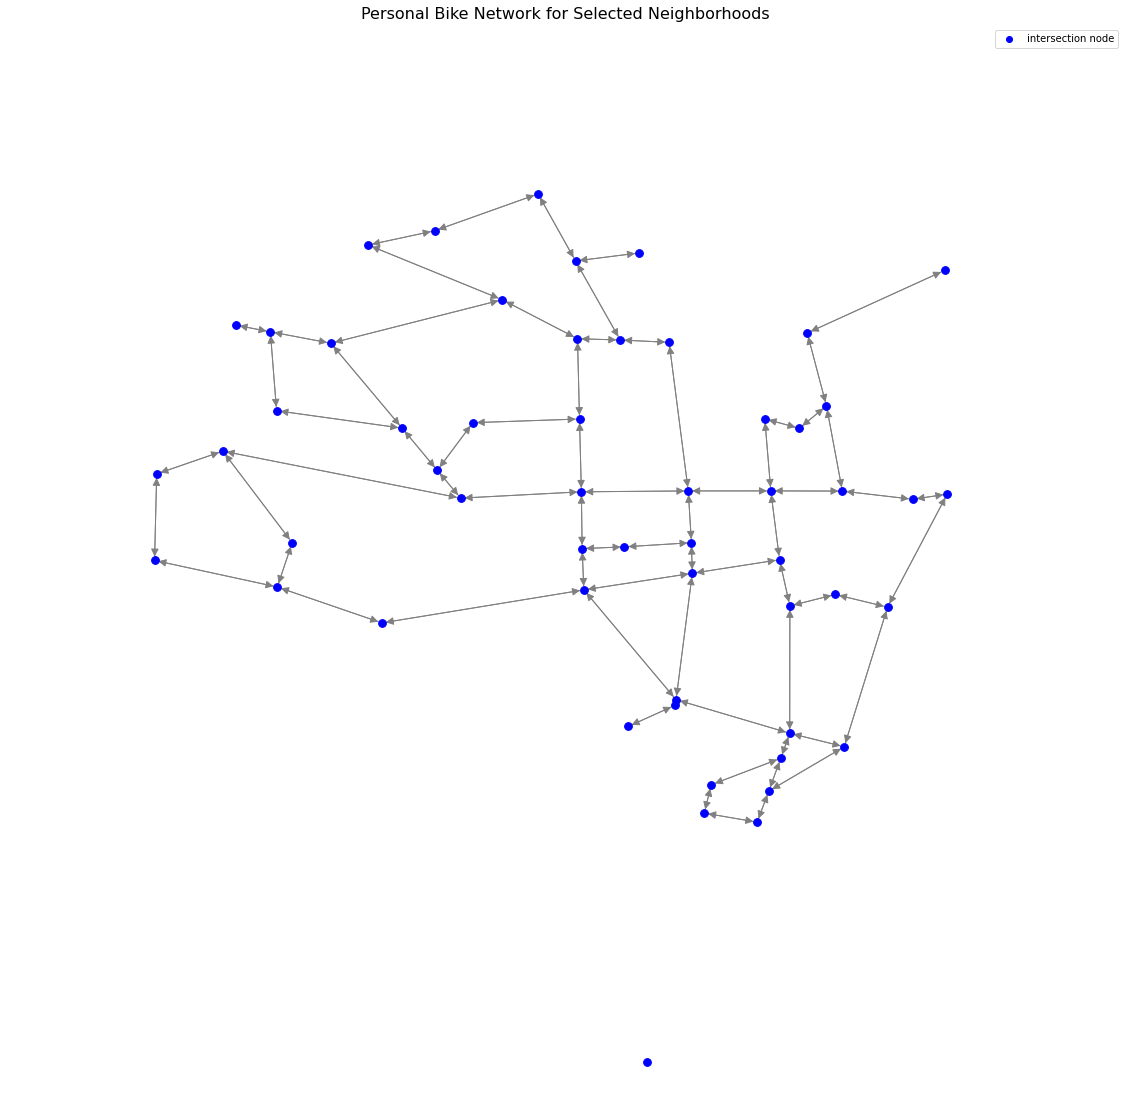

In [63]:
node_cmap = {'intersection node': 'blue'}
ax = draw_graph(G_pb, 'blue', node_cmap, edge_color='gray')
ax.set_title('Personal Bike Network for Selected Neighborhoods', fontsize=16)

## Bikeshare

**Get bikeshare Data**

In [64]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations

In [65]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

In [66]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St,9,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


In [67]:
# add position column, to be used when converting to networkx graph object
bs_df['nx_pos'] = bs_df.apply(lambda p: nx_pos(p['Longitude'], p['Latitude']), axis=1)

**Convert to geo df and clip to selected neighborhoods**

In [68]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df

In [69]:
# Clip the bs node network
bs_depots_clip = gpd.clip(bs_gdf, pgh_nhoods_mask)

<AxesSubplot:>

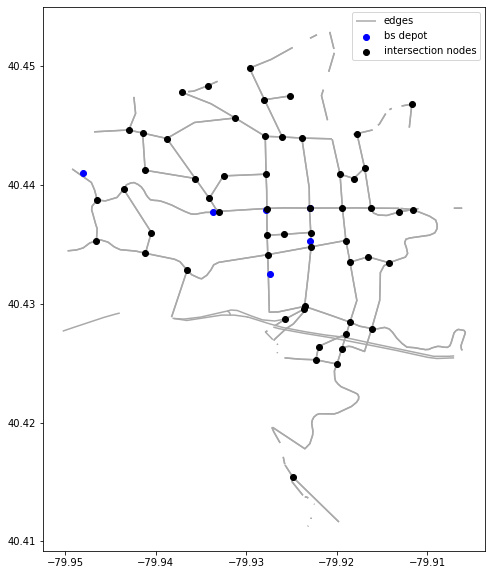

In [70]:
plot_nodes_and_edges([(bs_depots_clip, 'blue', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)

In [71]:
# data: 
# 1) bike_nodes_clip: intersection nodes
# 2) bike_edges_clip: road nodes
# 3) bs_depots_clip: depot nodes

**Create edge from bikeshare depot to nearest network node** <br>
This is the same procedure as what was used for the park and ride stations

In [72]:
bs_depots_clip[['nn_geom', 'nn_ID', 'nn_dist']] = bs_depots_clip.apply(lambda row: near(row['geometry'], bike_nodes_clip), axis=1).tolist()
bs_depots_clip.head()
# add linestring beween each pnr facility and its nn (for graphing)
depot_cnx_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in bs_depots_clip.iterrows()]
depot_cnx_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(depot_cnx_edges), crs='EPSG:4326')
depot_cnx_edges_gdf.head()

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda

,Station #,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
36,1037,Frew St & Schenley Dr,20,40.441032,-79.948042,"{'pos': (-79.948042, 40.441032)}",POINT (-79.94804 40.44103),POINT (-79.946459 40.438736),1320,0.002789
62,1070,Hobart St & Wightman St,5,40.432510,-79.927340,"{'pos': (-79.92733955, 40.43251029)}",POINT (-79.92734 40.43251),POINT (-79.927601 40.434139),3591,0.00165
61,1069,Beacon St & Murray Ave,6,40.435319,-79.922887,"{'pos': (-79.92288709, 40.43531949)}",POINT (-79.92289 40.43532),POINT (-79.922813 40.434797),6097,0.000528
77,49251,Schenley Dr & Forbes Ave,6,40.437753,-79.933637,"{'pos': (-79.93363738, 40.43775296)}",POINT (-79.93364 40.43775),POINT (-79.933038 40.437777),6247,0.0006
78,49261,Wightman St & Forbes Ave,5,40.437916,-79.927812,"{'pos': (-79.92781162, 40.43791627)}",POINT (-79.92781 40.43792),POINT (-79.927711 40.438028),4054,0.00015


,geometry
0,"LINESTRING (-79.94804 40.44103, -79.94646 40.4..."
1,"LINESTRING (-79.92734 40.43251, -79.92760 40.4..."
2,"LINESTRING (-79.92289 40.43532, -79.92281 40.4..."
3,"LINESTRING (-79.93364 40.43775, -79.93304 40.4..."
4,"LINESTRING (-79.92781 40.43792, -79.92771 40.4..."


<AxesSubplot:>

Text(0.5, 1.0, 'Bikeshare Network')

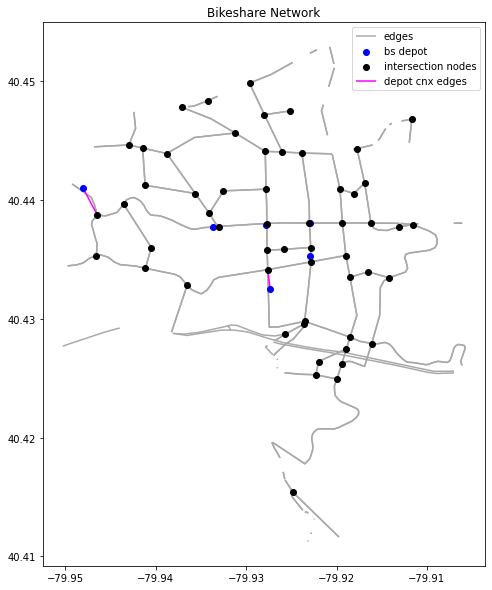

In [73]:
ax = plot_nodes_and_edges([(bs_depots_clip, 'blue', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)
depot_cnx_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='depot cnx edges')
ax.set_title('Bikeshare Network')
ax.legend()

### Convert to networkx graph

In [74]:
# first add intersection nodes and rename
G_bs = G_pb.copy()  
prefix = 'bs'
G_bs = rename_nodes(G_bs, prefix)

In [75]:
bs_depots_clip.insert(0, 'ID', bs_depots_clip.apply(lambda row: 'bsd'+str(row['Station #']), axis=1))
bs_depots_clip.head(2)
depot_list = list(zip(bs_depots_clip.ID, bs_depots_clip.nx_pos))
depot_list[:2]

,ID,Station #,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
36,bsd1037,1037,Frew St & Schenley Dr,20,40.441032,-79.948042,"{'pos': (-79.948042, 40.441032)}",POINT (-79.94804 40.44103),POINT (-79.946459 40.438736),1320,0.002789
62,bsd1070,1070,Hobart St & Wightman St,5,40.432510,-79.927340,"{'pos': (-79.92733955, 40.43251029)}",POINT (-79.92734 40.43251),POINT (-79.927601 40.434139),3591,0.00165


[('bsd1037', {'pos': (-79.948042, 40.441032)}),
 ('bsd1070', {'pos': (-79.92733955, 40.43251029)})]

In [76]:
# then add depot nodes with IDs
G_bs.add_nodes_from(depot_list)

# add the depot cnx edges
bs_depots_clip['nn_nodeID'] = bs_depots_clip.apply(lambda row: 'bs'+str(row['nn_ID']), axis=1)
edges_out = list(zip(bs_depots_clip['ID'], bs_depots_clip['nn_nodeID']))
edges_in = list(zip(bs_depots_clip['nn_nodeID'], bs_depots_clip['ID']))
G_bs.add_edges_from(edges_out + edges_in)  

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [77]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pb, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_bs, prev_max_linkID)

431

In [78]:
G_bs.size()
G_pb.size() + len(bs_depots_clip) * 2  # this checks out

152

152

**This is the graph that will be used to find precomputed edge weights of shortcut edges between depot nodes**

Text(0.5, 1.0, 'Bikeshare Network')

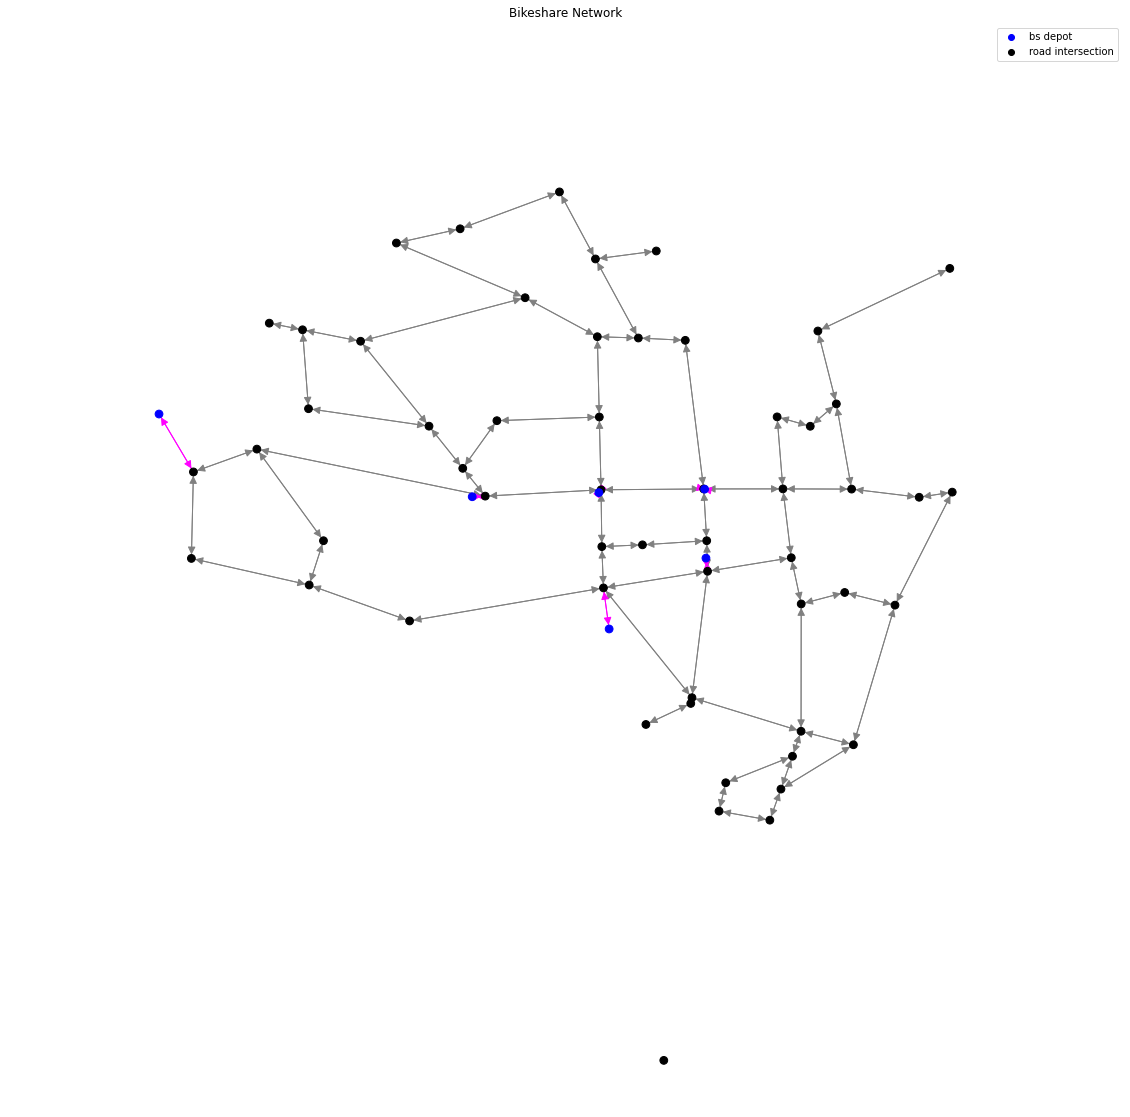

In [79]:
node_color = ['blue' if n.startswith('bsd') else 'black' for n in G_bs.nodes]
edge_color = ['magenta' if (e[0].startswith('bsd') or e[1].startswith('bsd')) else 'gray' for e in G_bs.edges]
ax = draw_graph(G_bs, node_color, {'road intersection':'black', 'bs depot':'blue'}, edge_color)
ax.set_title('Bikeshare Network')
# TO DO: add legend for edge color. See small network for example

### Precompute the bikeshare network

This is the graph that will be used in the supernetwork

<AxesSubplot:>

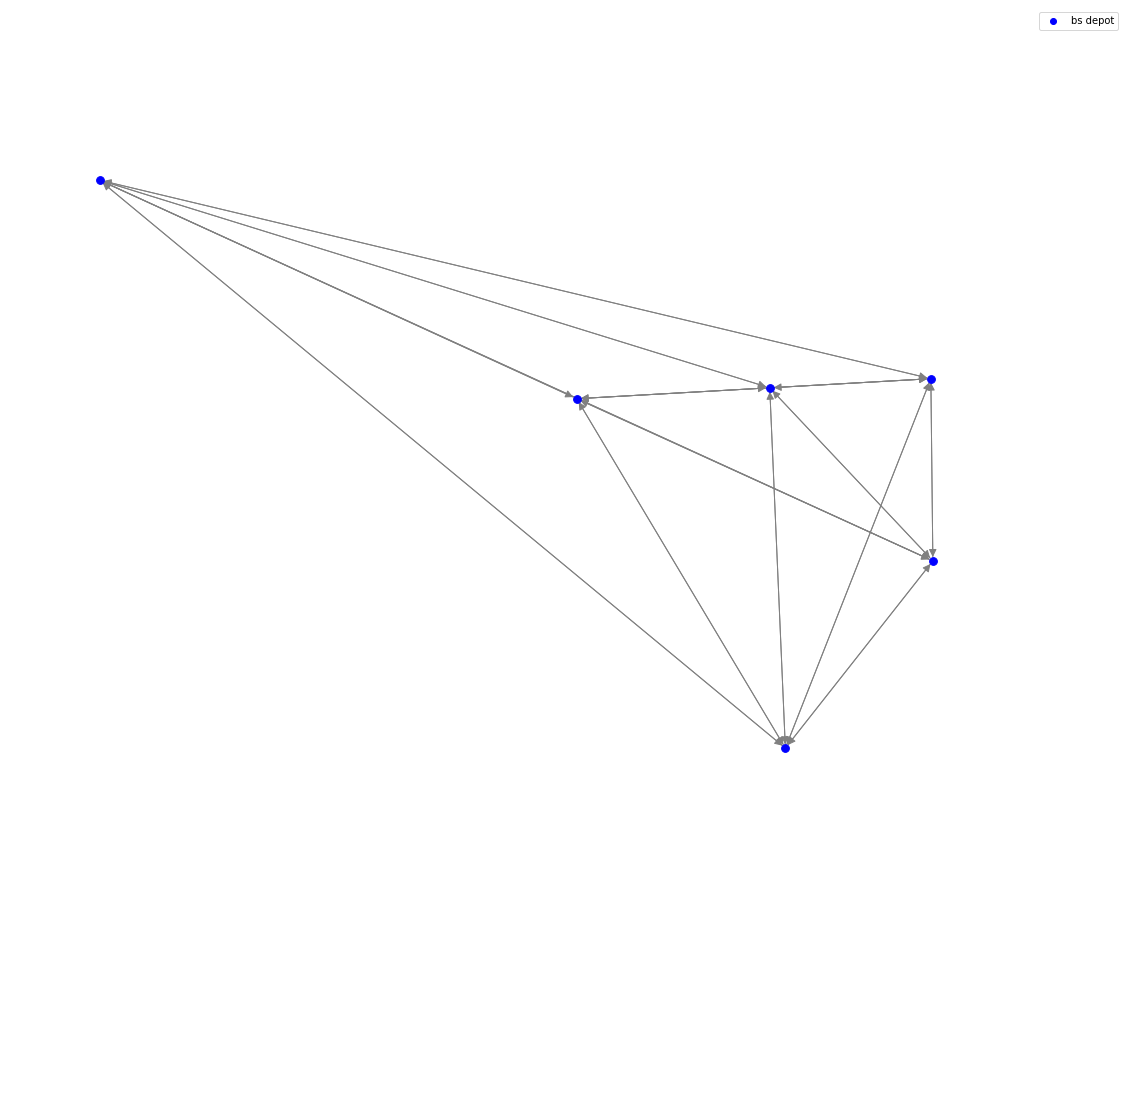

In [80]:
G_bs_pre = to_nx_graph(bs_depots_clip)  # only include depots
G_bs_pre = rename_nodes(G_bs_pre, 'bs')

bs_depot_pairs = list(itertools.permutations(list(G_bs_pre.nodes), 2))
# Add shortcut b/w all depot edges. Don't calculate shortcut edge weight yet; will be done in subsequent step
for e in bs_depot_pairs:
    G_bs_pre.add_edge(*e)
draw_graph(G_bs_pre, 'blue', {'bs depot': 'blue'}, 'gray')

In [81]:
print('Number of shortcut edges = ', (len(G_bs_pre.nodes)*(len(G_bs_pre.nodes)-1)))
len(G_bs_pre.edges)  # checks out

Number of shortcut edges =  30


30

In [82]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pb, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_bs_pre, prev_max_linkID)

431

In [83]:
G_bs_pre.nodes

NodeView(('bs1037', 'bs1070', 'bs1069', 'bs49251', 'bs49261', 'bs1068'))

**To do: use base bikeshare network to precompute edge cost for shortcut bikeshare network**

## Public Transit

GTFS data was processed in Public_Transit_Data.ipynb. Here we read the processed data.

In [84]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/PortAuthority/GTFS/')
os.chdir(new_dir)
filename = 'PT_route_data.csv'   

In [85]:
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/PortAuthority/GTFS'

In [86]:
pt_df = pd.read_pickle(filename)  # read file
pt_df.columns = ['route_id', 'direction_id', 'stop_sequence', 'point_sequence']
pt_df["rt_node_id"] = 'rt' + '_' + pt_df['route_id'] + '_' + pt_df['direction_id'].astype(str)
pt_df['geometry'] = pt_df['point_sequence'].apply(lambda x: LineString(x))  # add linestring data for routing
pt_gdf = gpd.GeoDataFrame(pt_df, crs='EPSG:4326')  # convert to gdf 
pt_gdf_clip = gpd.clip(pt_gdf, pgh_nhoods_mask)  # clip to study area
pt_gdf_clip.head()

,route_id,direction_id,stop_sequence,point_sequence,rt_node_id,geometry
63,53L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_53L_0,"MULTILINESTRING ((-79.94983 40.42841, -79.9480..."
64,53L,1,"[21187, 20906, 21465, 9616, 21224, 21225, 2122...","[POINT (-79.93244199999999 40.361767), POINT (...",rt_53L_1,"MULTILINESTRING ((-79.91966 40.41168, -79.9229..."
61,52L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_52L_0,"MULTILINESTRING ((-79.94983 40.42841, -79.9480..."
81,61A,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...",rt_61A_0,"MULTILINESTRING ((-79.94690 40.44437, -79.9422..."
71,57,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_57_0,"MULTILINESTRING ((-79.92374 40.41065, -79.9231..."


<AxesSubplot:>

Text(0.5, 1.0, 'Single Route and Associated Stops, superimposed over study area')

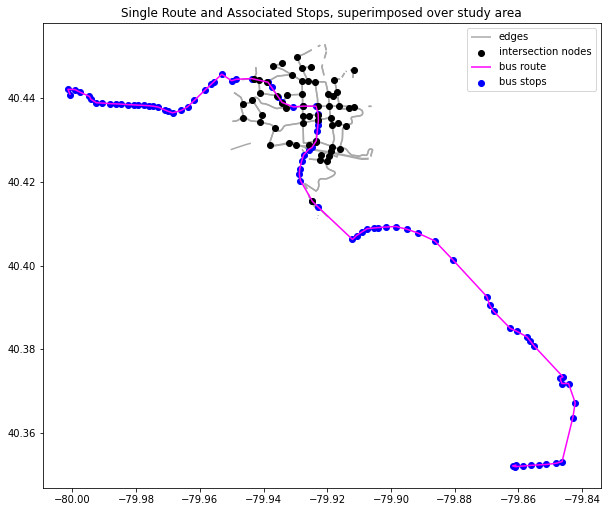

In [87]:
# Testing: 
temp = pt_gdf.loc[(pt_gdf.route_id == '61C') & (pt_gdf.direction_id == 1)]
#fig, ax = plt.subplots(figsize=(10,10))
ax = plot_nodes_and_edges([(nodes_clip, 'black', 'intersection nodes')], edges_clip)
temp.plot(ax=ax, zorder=2, color='magenta', label='bus route')
xs = [point.x for point in temp['point_sequence'].values[0]]
ys = [point.y for point in temp['point_sequence'].values[0]]
ax.scatter(xs, ys, color='blue', label = 'bus stops')
ax.legend()
ax.set_title('Single Route and Associated Stops, superimposed over study area')

### Convert to networkx graph

**Nodes**

In [88]:
# first we need the coordinates of all the bus stops 
# we will ues the stops.txt file directly from GTFS
stops_df = pd.read_csv('stops.txt')
stops_df.head(3)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,4875,4875,ARLINGTON AVE + FREDERICK,NaN,40.417694,-79.982614,01,NaN,NaN,NaN,NaN,0
1,4876,4876,ARLINGTON AVE + KOEHLER,NaN,40.417637,-79.984507,01,NaN,NaN,NaN,NaN,0
2,4877,4877,ARLINGTON AVE + S 18TH,NaN,40.417582,-79.986232,01,NaN,NaN,NaN,NaN,0


In [93]:
stops_df['nx_pos'] = stops_df.apply(lambda p: nx_pos(p['stop_lon'], p['stop_lat']), axis=1)
stops_df['ID'] = stops_df['stop_id']
stops_df['geometry'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat, crs='EPSG:4326')
stops_gdf = gpd.GeoDataFrame(stops_df, crs='EPSG:4326')
stops_gdf_clip = gpd.clip(stops_gdf, pgh_nhoods_mask)
len(stops_gdf_clip.stop_id.unique())

159

159

<AxesSubplot:>

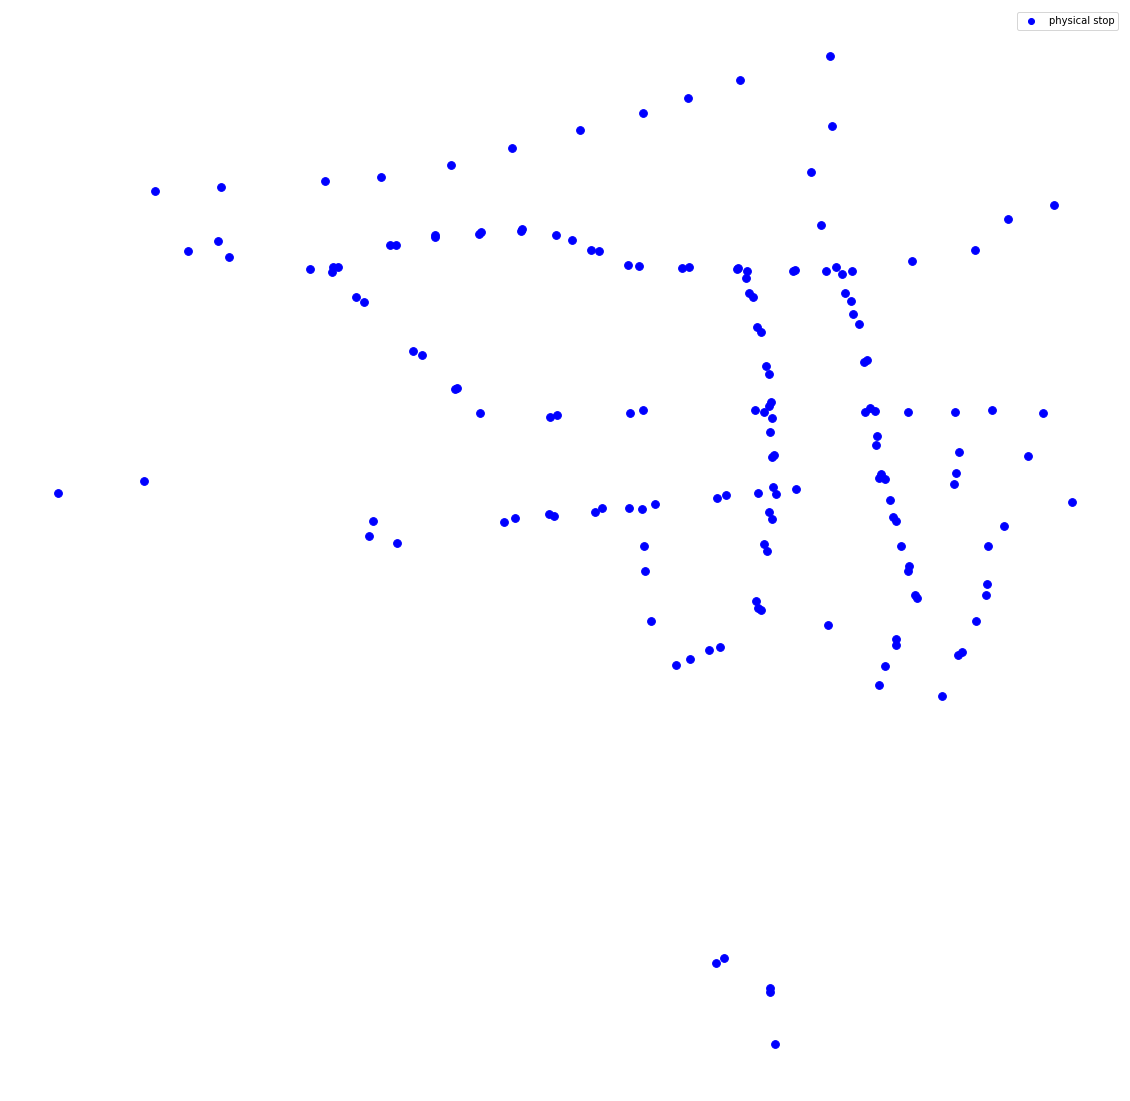

In [102]:
G_pt = to_nx_graph(stops_gdf_clip)
G_pt = rename_nodes(G_pt, 'ps')
len(list(G_pt.nodes))
draw_graph(G_pt, 'blue', {'physical stop':'blue'}, 'grey')

In [95]:
# # construct an "offset geometry" for route nodes (for visualization purposes, so that route nodes do not exactly
# # overlap physical stop nodes)
# stops_gdf_clip['offset_geom'] = stops_gdf_clip['geometry'].translate(0.001, 0.001)
# rt_nodes_gdf = stops_gdf_clip[['ID', 'offset_geom']].rename(columns={'offset_geom':'geometry'})
# rt_nodes_gdf['x'] = rt_nodes_gdf['geometry'].apply(lambda p: p.x)
# rt_nodes_gdf['y'] = rt_nodes_gdf['geometry'].apply(lambda p: p.y)
# rt_nodes_gdf['nx_pos'] = rt_nodes_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1) 
# rt_nodes_gdf.head()
# G_rt = to_nx_graph(rt_nodes_gdf)
# G_rt = rename_nodes(G_rt, 'rt')

**Now add route nodes:** 
1. Use the route_nodes_by_stop.csv file to see how many routes use a physical stop
1. For each physical stop, construct as many route nodes as there are routes
1. Then, use the stop_sequence to construct as many route edges as there are routes that pass along the segment

In [96]:
route_nodes_df = pd.read_pickle('route_nodes_by_stop.csv').drop(columns=['index'])
route_nodes_df['geometry'] = gpd.points_from_xy(route_nodes_df['stop_lon'], route_nodes_df['stop_lat'])
route_nodes_gdf = gpd.GeoDataFrame(data=route_nodes_df, crs='EPSG:4326')
route_nodes_gdf['nx_pos'] = route_nodes_gdf.apply(lambda p: nx_pos(p['stop_lon'], p['stop_lat']), axis=1) 
route_nodes_gdf['ID'] = 'rt' + route_nodes_gdf['stop_id'] + '_' + route_nodes_gdf['route_dir_id']
route_nodes_gdf = gpd.clip(route_nodes_gdf, pgh_nhoods_mask)  # clip the dataset
route_nodes_gdf.shape
route_nodes_gdf.head()

(384, 7)

,stop_id,route_dir_id,stop_lat,stop_lon,geometry,nx_pos,ID
8958,12123,57_0,40.411704,-79.922799,POINT (-79.92280 40.41170),"{'pos': (-79.922799, 40.411704)}",rt12123_57_0
6241,10959,57_0,40.413866,-79.922983,POINT (-79.92298 40.41387),"{'pos': (-79.922983, 40.413866)}",rt10959_57_0
6240,10959,52L_0,40.413866,-79.922983,POINT (-79.92298 40.41387),"{'pos': (-79.922983, 40.413866)}",rt10959_52L_0
6243,10959,61C_0,40.413866,-79.922983,POINT (-79.92298 40.41387),"{'pos': (-79.922983, 40.413866)}",rt10959_61C_0
6244,10959,64_0,40.413866,-79.922983,POINT (-79.92298 40.41387),"{'pos': (-79.922983, 40.413866)}",rt10959_64_0


In [103]:
# build route nodes
G_rt = to_nx_graph(route_nodes_gdf)
G_rt.nodes['rt12123_57_0']
G_pt.nodes['ps12123']  # confirmation that route node and physical stop node have some position if represent same stop
len(list(G_rt.nodes))
len(list(G_pt.nodes))  

{'pos': (-79.922799, 40.411704)}

{'pos': (-79.922799, 40.411704)}

384

159

In [104]:
G_pt = nx.union_all([G_pt, G_rt])  # combine the physical stop nodes with route nodes

In [420]:
# # add a node attribute for the bus route(s) that pass through the stop node 
# filename = 'stops_routes_dir.csv'  # this file was created in Public_Transit_Data.ipynb
# stops_routes_dir_df = pd.read_pickle(filename)  # read file
# stops_routes_dir_df['nx_routes'] = stops_routes_dir_df.apply(lambda x: {'routes': x['route_dir_id']}, axis=1)
# stops_routes_dir_df['ps_id'] = 'ps' + stops_routes_dir_df['stop_id']
# stops_routes_dir_df['rt_id'] = 'rt' + stops_routes_dir_df['stop_id']
# stops_routes_dir_df['geometry'] = gpd.points_from_xy(stops_routes_dir_df['stop_lon'], stops_routes_dir_df['stop_lat'])
# stops_routes_dir_gdf = gpd.GeoDataFrame(stops_routes_dir_df, crs='EPSG:4326')
# stops_routes_dir_clip_gdf = gpd.clip(stops_routes_dir_gdf, pgh_nhoods_mask)  # clip the dataset
# stops_routes_dir_clip_gdf.shape
# stops_routes_dir_clip_gdf.head()

# # add attributes
# attr = dict(zip(stops_routes_dir_clip_gdf['ps_id'], stops_routes_dir_clip_gdf['nx_routes']))
# nx.set_node_attributes(G_pt, attr)
# attr = dict(zip(stops_routes_dir_clip_gdf['rt_id'], stops_routes_dir_clip_gdf['nx_routes']))
# nx.set_node_attributes(G_pt, attr)

Now for each node, we know its position as well as which route-dir pairs run through it
This will be important when building transfer edges and deconstructing the shortest path

In [104]:
#pt_gdf_clip.reset_index(inplace=True)

**Edges**

Now we need to add route edges and boarding/alighting edges. Consider the outbound Forbes/Morewood stop and the buses 61A, 61B, 61C, and 61D. For the Forbes/Morewood physical stop, we should have 4 route nodes to represent the 4 bus lines. Each route node should be connected to the physical stop node by a pair of boarding and alighting edges. All four bus lines travel to the Forbes/Murray physical stop. Ignore the intermediate stops for now. Then we would need to add 4 route edges between Forbes/Morewood and Forbes/Murray, one for each bus line. Similarly, the physical stop Forbes/Murray has 4 route nodes, one for each bus line.

This brings to light another point related to transfer edges. Consider the following example: a person boards the 61A at Forbes/Morewood and then transfers to the 61C and Forbes/Murray to continue along Murray. Even though there is no walking cost associated with the transfer (as it occurs at thes same physical stop), is there an inconvenience cost that needs to be incorporated? 

In [116]:
# recall that a route node ID is defined this way: 'rt'+'stop_id'+'_'+'rt_id'+'_'+'dir_id'
# ex: rt12123_57_0
# this is the format we need to match when creating route edges

In [118]:
list(G_pt.nodes)[:5]

['ps18458', 'ps10913', 'ps12123', 'ps10959', 'ps19375']

In [140]:
#route_nodes_gdf['ID'] = 'rt' + route_nodes_gdf['stop_id'] + '_' + route_nodes_gdf['route_dir_id']
pt_gdf_clip['route_dir_id'] = pt_gdf_clip['route_id'] + '_' + pt_gdf_clip['direction_id'].astype(str)
pt_gdf_clip.head(10)
pt_gdf_clip.shape

,route_id,direction_id,stop_sequence,point_sequence,rt_node_id,geometry,route_dir_id
63,53L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_53L_0,"MULTILINESTRING ((-79.94983 40.42841, -79.9480...",53L_0
64,53L,1,"[21187, 20906, 21465, 9616, 21224, 21225, 2122...","[POINT (-79.93244199999999 40.361767), POINT (...",rt_53L_1,"MULTILINESTRING ((-79.91966 40.41168, -79.9229...",53L_1
61,52L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_52L_0,"MULTILINESTRING ((-79.94983 40.42841, -79.9480...",52L_0
81,61A,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...",rt_61A_0,"MULTILINESTRING ((-79.94690 40.44437, -79.9422...",61A_0
71,57,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...",rt_57_0,"MULTILINESTRING ((-79.92374 40.41065, -79.9231...",57_0
82,61A,1,"[20936, 20937, 20721, 7399, 21639, 21640, 7046...","[POINT (-79.86834500000001 40.402335), POINT (...",rt_61A_1,"MULTILINESTRING ((-79.90031 40.43947, -79.9023...",61A_1
83,61B,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...",rt_61B_0,"MULTILINESTRING ((-79.94690 40.44437, -79.9422...",61B_0
87,61D,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...",rt_61D_0,"MULTILINESTRING ((-79.94690 40.44437, -79.9422...",61D_0
85,61C,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...",rt_61C_0,"MULTILINESTRING ((-79.94690 40.44437, -79.9422...",61C_0
86,61C,1,"[22902, 22899, 9892, 9894, 18174, 9896, 9897, ...","[POINT (-79.860598 40.352322), POINT (-79.8618...",rt_61C_1,"MULTILINESTRING ((-79.91966 40.41168, -79.9229...",61C_1


(29, 7)

In [122]:
#pt_gdf_clip.route_dir_id.tolist()
pt_gdf_clip.route_dir_id.tolist()[1]
pt_gdf_clip.route_dir_id.tolist()[2]
'rt' + '43' + '_' + pt_gdf_clip.route_dir_id.tolist()[0]

'53L_1'

'52L_0'

'rt43_53L_0'

In [157]:
# add route edges
route_dir_id_list = pt_gdf_clip.route_dir_id.tolist()

for i,s in enumerate(pt_gdf_clip['stop_sequence']):   # s is a sequential list of nodes
    potential_edges = list(zip(s[:len(s)], s[1:len(s)+1]))
    rt_edges = []
    for edge in potential_edges:  
        if (('ps'+edge[0] not in list(G_pt.nodes)) | ('ps'+edge[1] not in list(G_pt.nodes))):
            continue  # here we checked if both edge nodes are within the study area
        else:
            # build route edge
            rt_edge = ('rt' + edge[0] + '_' + route_dir_id_list[i],
                       'rt' + edge[1] + '_' + route_dir_id_list[i])
            rt_edges.append(rt_edge) 
    G_pt.add_edges_from(rt_edges)  # add route edges to the PT graph

In [158]:
# check
len(G_pt.nodes) 
len(G_pt.edges)

543

277

In [164]:
# add boarding and alighting edges
ba_edges = []
for n in list(G_pt.nodes):
    if n.startswith('rt'):   # is a route node
        # connect to associated physical stop
        phys_stop = 'ps' + re.sub('\D', '', (n.split('_')[0]))    # re.sub('\D', '', string) removes letters from string
        e_board = (n, phys_stop)
        e_alight = (phys_stop, n)
        ba_edges.extend([e_board, e_alight])
G_pt.add_edges_from(ba_edges)  # add board/alight edges to the graph
ba_edges[:10]  # test
len(ba_edges)

[('rt12123_57_0', 'ps12123'),
 ('ps12123', 'rt12123_57_0'),
 ('rt10959_57_0', 'ps10959'),
 ('ps10959', 'rt10959_57_0'),
 ('rt10959_52L_0', 'ps10959'),
 ('ps10959', 'rt10959_52L_0'),
 ('rt10959_61C_0', 'ps10959'),
 ('ps10959', 'rt10959_61C_0'),
 ('rt10959_64_0', 'ps10959'),
 ('ps10959', 'rt10959_64_0')]

768

In [171]:
n = 'rt10959_64_0'
G_pt.nodes[n]['pos'][0]

-79.922983

In [172]:
# offset the geometry of the route nodes, for visualization purposes
for n in G_pt.nodes:
    if n.startswith('rt'):
        G_pt.nodes[n]['pos'] = (G_pt.nodes[n]['pos'][0] + 0.001, G_pt.nodes[n]['pos'][1] + 0.001)

**Draw the graph, nodes and route edges included** <br>
Confirm that traversal edges run between route nodes boarding/alighting edges run between physical stops and route nodes <br>
*Note*: Since many route nodes may be associated with a single physical stop, the graph below will have overlapping route nodes and overlapping boarding/alighting edges

Text(0.5, 1.0, 'PT graph with physical stops and offset route nodes')

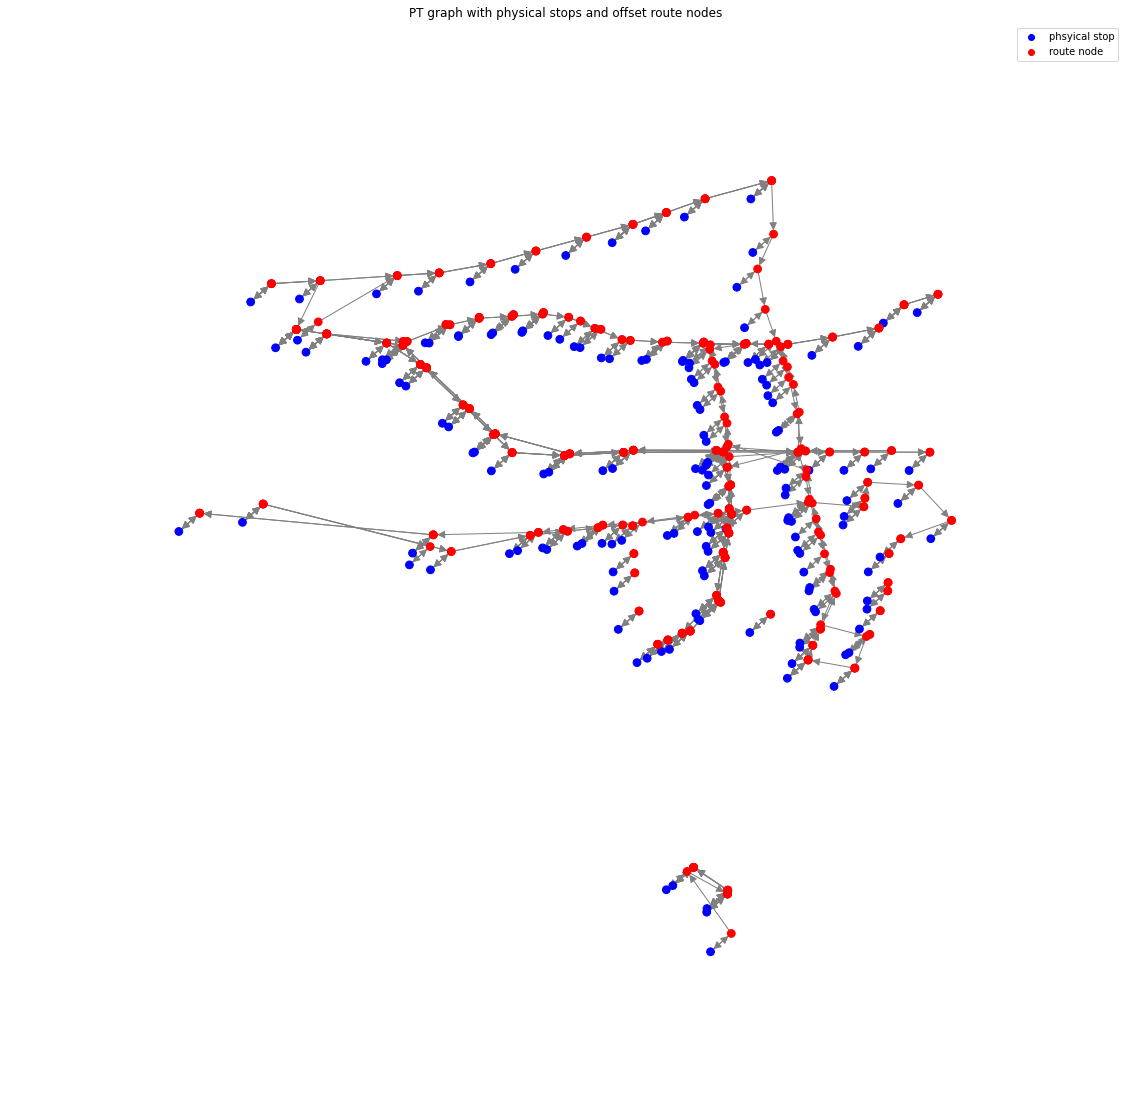

In [174]:
node_color = ['blue' if n.startswith('ps') else 'red' for n in G_pt.nodes]
node_cmap = {'phsyical stop':'blue', 'route node':'red'}
ax = draw_graph(G_pt, node_color, node_cmap, 'gray')
ax.set_title('PT graph with physical stops and offset route nodes')

In [175]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_bs_pre, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_pt, prev_max_linkID)

461

In [176]:
len(G_pt.edges)

1045

## Scooter

In [177]:
G_sc = G_pb.copy()
G_sc = rename_nodes(G_sc, 'sc')

In [178]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pt, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_sc, prev_max_linkID)

1506

**Subsequently: generate historical scooter location data, to be used in assignment of transfer edge costs**

# Build the supernetwork

In [179]:
# this dict defines which graphs correspond to each mode type 
all_graphs_dict = {'bs':G_bs_pre, 'pt':G_pt, 't':G_tnc, 'pv':G_pv, 'pb':G_pb, 'sc':G_sc}
# this dict defines the node names corresponding to each mode type 
all_modes_nodes = {'bs':['bs'], 'pt':['ps','rt'], 't':['t'], 'sc':['sc'], 'pv':['pv','k'], 'pb':['pb']}  

In [180]:
# define which nodes are fixed and which come from flexible networks 
all_fix_pre = ['bs','ps','k']  # prefix for fixed nodes
all_flex_pre = ['t', 'pb', 'pv', 'sc']  # prefix for flexible dropoff nodes

### Choose which networks to include in the supernetwork 

In [181]:
# this list is the parameter that defines which modes to include in the supernetwork
modes_included = ['bs','pt','t','sc','pv']   # omit the personal bike network since we are included pv and tnc

In [182]:
# this dict defines which modes and nodes are included in the supernetwork
modes_nodes_included = {k:v for k,v in all_modes_nodes.items() if k in modes_included}

networks_included = [all_graphs_dict[m] for m in modes_included]  # set([all_graphs_dict[m] for m in modes_included])

# prefixes for fixed nodes in the supernetwork
fix_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_fix_pre]
# prefixes for flex nodes in the supernetwork
flex_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_flex_pre]
print('fixed nodes included = ', fix_pre)
print('flex nodes included = ', flex_pre)

fixed nodes included =  ['bs', 'ps', 'k']
flex nodes included =  ['t', 'sc', 'pv']


## Combine the unimodal networks 

In [183]:
# combine all the graphs together into one supernetwork
G_u = nx.union_all(networks_included)

In [184]:
def node_color_list(G):
    node_color = []
    for n in G.nodes:
        if n.startswith('ps'):
            node_color.append('blue')
        if n.startswith('rt'):
            node_color.append('dimgray')
        if n.startswith('sc'):
            node_color.append('darkcyan')
        if n.startswith('bs'):
            node_color.append('green')
        if n.startswith('t'):
            node_color.append('red')
        if n.startswith('pv'):
            node_color.append('purple')
        if n.startswith('k'):
            node_color.append('black')    
    return node_color

Text(0.5, 1.0, 'Supernetwork (selected networks superimposed)')

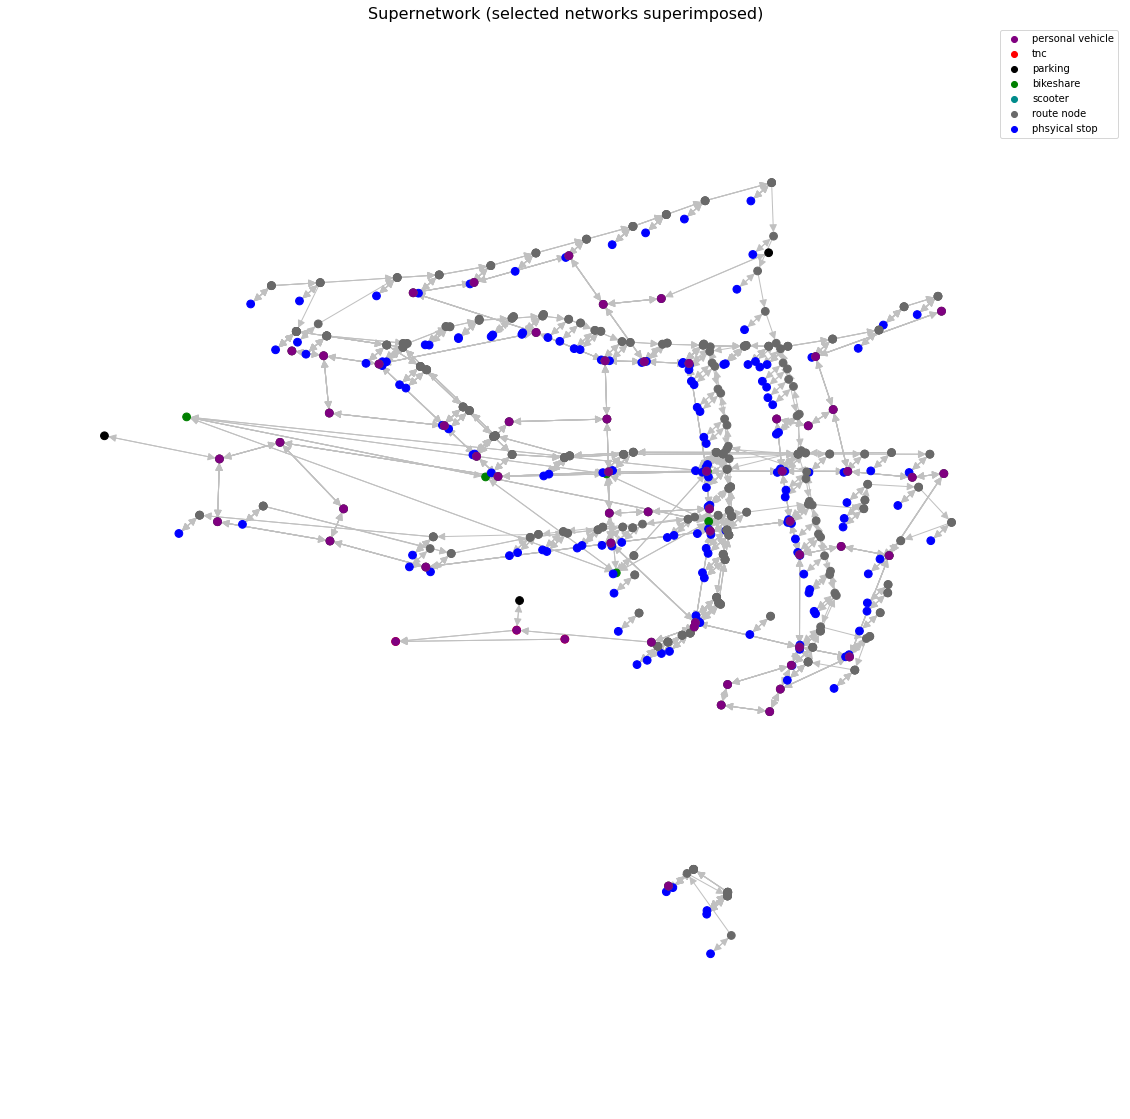

In [185]:
node_cmap = {'phsyical stop':'blue', 'route node':'dimgray', 'scooter':'darkcyan', 'bikeshare':'green',
             'tnc':'red', 'personal vehicle':'purple', 'parking':'black'}
node_color = node_color_list(G_u)
ax = draw_graph(G_u, node_color, node_cmap, 'silver')
ax.set_title('Supernetwork (selected networks superimposed)', fontsize=16)
# as expected, the networks overlap

In [306]:
# Let's adjust the supernetwork to see if it still looks right

In [186]:
# input: graph and jitter parameter (how much to adjust the x and y coordinates)
# output: adjusted graph with jittered coordinates
# this function is only for visualization purposes. the original coordinates should remain unchanged
def jitter_nodes(G, jitter_param):
    #G_adj = G.copy()
    j = jitter_param
    # adjust the nodes positions in the copy 
    for node in G.nodes.keys():
        #print(G_tnc.nodes[node]['pos'])
        adj_x = G.nodes[node]['pos'][0] + jitter_param
        #print(adj_x)
        adj_y = G.nodes[node]['pos'][1] + jitter_param
        #print(adj_y)
        nx.set_node_attributes(G, {node: {'pos':(adj_x, adj_y)}})
    return G

In [187]:
modes_included = ['t', 'bs', 'pt', 'sc', 'pv']
all_graphs_dict

{'bs': <networkx.classes.digraph.DiGraph at 0x7f894c627670>,
 'pt': <networkx.classes.digraph.DiGraph at 0x7f89309d2610>,
 't': <networkx.classes.digraph.DiGraph at 0x7f894c775850>,
 'pv': <networkx.classes.digraph.DiGraph at 0x7f894badebb0>,
 'pb': <networkx.classes.digraph.DiGraph at 0x7f894bcfaaf0>,
 'sc': <networkx.classes.digraph.DiGraph at 0x7f892e3226d0>}

In [188]:
# problem is that tnc, pb, and pv intersections overlap. 
# define and adjusted graph for drawing purposes; not the real graph in physical world

# the TNC graph is the reference graph for drawing since it is the basic road network; # it will remain in its original position 
adjusted_mode_dict = {}   #{'t': G_tnc}
  
# adjust the graphs in the supernetwork using the jitter function
# this is strictly for plotting
for j, m in enumerate(modes_included):  
    #if m != 't':  # tnc graph is the "base" road network so it will not be adjusted
    G_adj = all_graphs_dict[m].copy()
    jitter_nodes(G_adj, jitter_param=(j/100)*2)  # first graph (tnc) will not be adjusted, which is appropriate since it's the basemap
    adjusted_mode_dict[m] = G_adj

Text(0.5, 1.0, 'Supernetwork, where phsyically overlapping networks are offset')

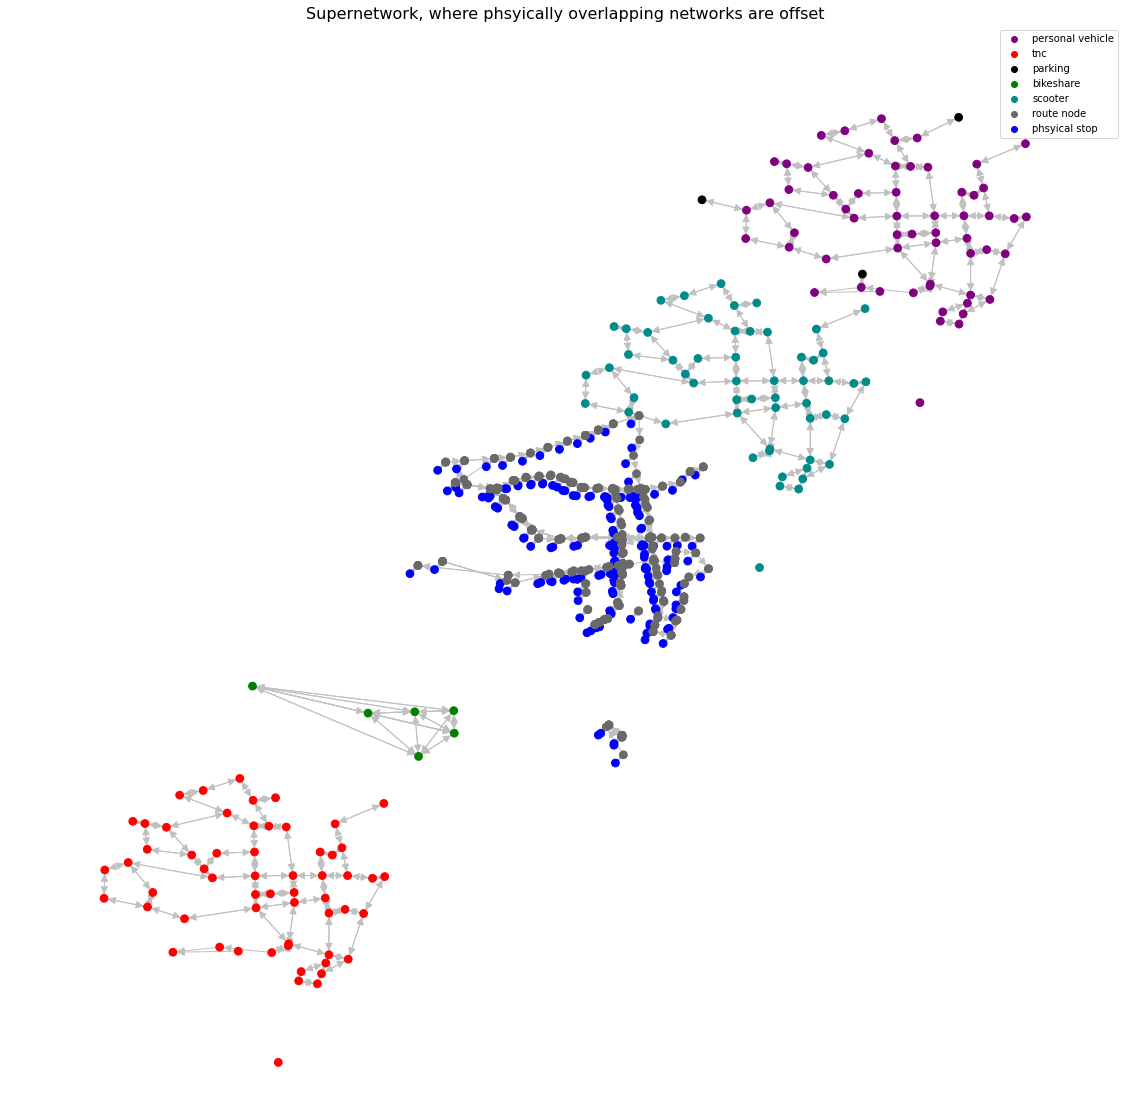

In [189]:
G_u_adj = nx.union_all(G for G in adjusted_mode_dict.values()) 
node_color = node_color_list(G_u_adj)
ax = draw_graph(G_u_adj, node_color, node_cmap, 'silver')
ax.set_title('Supernetwork, where phsyically overlapping networks are offset', fontsize=16)

In [311]:
# Node labels included
# def draw_graph(G, node_color, node_cmap, edge_color):
#     # draw the graph in networkx
#     node_coords = nx.get_node_attributes(G, 'pos')    
#     fig, ax = plt.subplots(figsize=(20,20))
#     nx.draw(G, pos=node_coords, with_labels=True, font_size=12, font_color='black',  font_weight = 'bold',
#             node_size=60, node_color=node_color, edge_color=edge_color, arrowsize=16, ax=ax)
#     # add legend for node color    
#     inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
#     for v in set(inv_node_cmap.keys()):
#         ax.scatter([],[], c=v, label=inv_node_cmap[v])
#     ax.legend(loc = 'upper right')
#     return ax

# Traversal Edge Costs

In [190]:
speed_params = {'bs':3, 'pt':4, 't':6, 'pv':6, 'k':6, 'pb':3, 'sc':3, 'w':1}  # avg speed

## Define time-dependent edge costs that are completely random

Consider 10 time intervals, each of length 30 seconds

In [275]:
num_intervals = 10  
length_interval = 30

In [339]:
G_test = G_u.copy()  # helpful to do things on a graph copy 
# find random edge costs for all edges EXCEPT for the precomputed bike share edges. we will do this below
# remove bikeshare edges, find remaining edge costs, then add them back? probably a more efficient way to do this 
bs_edges = [(e[0], e[1]) for e in G_u.edges if (e[0].startswith('bs') or e[1].startswith('bs'))]
G_test.remove_edges_from(bs_edges)  # remove bs edges
random_edge_costs(G_test, num_intervals, length_interval, 20, 30)  # find random edge costs for remaining edges. 6 intervals, each 30 sec long
G_u = G_test.copy()  # this is the multimodal network WITHOUT bikeshare

**Precomputation of bikeshare shortcut edge cost**

In [340]:
# Find the depots in G_bs
depot_nodes = [n for n in G_bs.nodes if n.startswith('bsd') ]
depot_pairs = list(itertools.permutations(depot_nodes, 2))

# Set edge cost for each edge in the full bikeshare network
random_edge_costs(G_bs, num_intervals, length_interval, 20, 30)  # random edge cost (including depot connection edges)
cost_keys = ['cost'+str(i) for i in range(num_intervals)]
# Here we need to reassign the edge costs for depot connection edges --- unif(20,60) is relatively too large. 
# For now, choose a static cost of 3
for e in G_bs.edges:
    if (e[0].startswith('bsd') | e[1].startswith('bsd')):  # a depot connection edge
        bs_cost_dict = dict(zip(cost_keys, [3]*num_intervals))
        nx.set_edge_attributes(G_bs, {(e[0], e[1]): bs_cost_dict})
        
# Precompute the shortest path between each pair of depot nodes 
for e in depot_pairs:
    # find shortest path b/w depot nodes using "cost1" as the weight
    sp = nx.dijkstra_path(G_bs, e[0], e[1], 'cost1')  
    sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)]
    total_cost = sp_total_cost(G_bs, sp_edges, 'cost1') 
     # make the cost dict, which is constant by time of day
    bs_cost_dict = dict(zip(cost_keys, [total_cost]*num_intervals))
    # now add edges back to G_u & set edge cost attributes
    e0, e1 = e[0].replace('bsd','bs'), e[1].replace('bsd','bs')
    G_u.add_edge(e0, e1)
    nx.set_edge_attributes(G_u, {(e0, e1): bs_cost_dict})

Total cost of the shortest path from org to dst =  97.33
[3, 22.155794063800265, 22.168888999138467, 20.488743407930098, 26.517117260900246, 3]
Total cost of the shortest path from org to dst =  121.89
[3, 22.155794063800265, 22.168888999138467, 20.488743407930098, 26.517117260900246, 24.563843779970707, 3]
Total cost of the shortest path from org to dst =  51.88
[3, 25.601070154570863, 20.27476327784437, 3]
Total cost of the shortest path from org to dst =  73.88
[3, 25.601070154570863, 20.27476327784437, 22.00512658973488, 3]
Total cost of the shortest path from org to dst =  94.77
[3, 25.601070154570863, 20.27476327784437, 22.00512658973488, 20.892379377616376, 3]
Total cost of the shortest path from org to dst =  105.15
[3, 25.938706125225913, 27.567604879506746, 22.688647010478213, 22.957813686698138, 3]
Total cost of the shortest path from org to dst =  30.56
[3, 24.563843779970707, 3]
Total cost of the shortest path from org to dst =  88.69
[3, 29.208590554237198, 29.37008466439

In [341]:
#G_u.edges[('bs1038','bs1044')]

In [342]:
# define edges of initial graph as traversal
# traversal edges
nx.set_edge_attributes(G_u, 'traversal', 'type')  # real graph
nx.set_edge_attributes(G_u_adj, 'traversal', 'type')  # adj graph

In [343]:
# Reassign boarding and alighting edge costs --- unif(20,60) is relatively too large
# Similar to depot connection edges, we will assign a cost of 3
for e in G_u.edges:
    if (e[0].startswith('ps') | e[1].startswith('ps')):
        brd_alight_cost_dict = dict(zip(cost_keys, [3]*num_intervals))
        nx.set_edge_attributes(G_u, {(e[0], e[1]): brd_alight_cost_dict})

In [344]:
#G_u.edges["ps12123", "rt12123"]

# Transfer Edges

## Step 1. Find great circle distance between all nodes in the graph

In [345]:
# make node_ID map of form {id_number: node_name}. also make inverse node ID map of form {node_name: id_number}
# ex  {0:bs1  1:bs2  ...}
nid_map = dict(zip(range(len(list(G_u.nodes))), G_u.nodes))
inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  
# separate nid map into fixed and flex
# separate nodes depending on whether fixed or flex network 
nid_map_fixed = {key:val for key,val in nid_map.items() if mode(val) in fix_pre}  # nid_map for fixed network nodes
nid_map_flex = {key:val for key,val in nid_map.items() if mode(val) in flex_pre}  # nid_map for flex network nodes

In [346]:
coord_matrix = get_coord_matrix(G_u, nid_map)  # np array where row i contains the lat/long pair of node i
# gcd distance matrix: gcd_dist[i,j] is the great circle distance from node i to node j
gcd_dist = np.empty([len(nid_map), len(nid_map)])
for i in range(gcd_dist.shape[0]):
    dist_to_all_nodes = calc_great_circle_dist(coord_matrix[i], coord_matrix)  # calc distance from node i to all other nodes
    gcd_dist[i] = dist_to_all_nodes  # calc_great_circle_dist is a function defined above 

In [347]:
gcd_dist[:5,:5]

array([[0.00000000e+00, 1.23769533e+00, 1.38042361e+00, 7.90623035e-01,
        1.08537726e+00],
       [1.23769533e+00, 0.00000000e+00, 3.04136361e-01, 4.90810797e-01,
        3.74331815e-01],
       [1.38042361e+00, 3.04136361e-01, 0.00000000e+00, 5.89801049e-01,
        3.15046268e-01],
       [7.90623035e-01, 4.90810797e-01, 5.89801049e-01, 0.00000000e+00,
        3.06562906e-01],
       [1.08537726e+00, 3.74331815e-01, 3.15046268e-01, 3.06562906e-01,
        8.34224374e-05]])

In [348]:
bbox_nhoods = pgh_nhoods_union['geometry'].bounds.T.to_dict()[0]  # bounding box of neighborhood polygon layer
bbox_nhoods

{'minx': -79.9503627830723,
 'miny': 40.4105719527786,
 'maxx': -79.8985109647237,
 'maxy': 40.4529019749748}

## Step 2. Scooter location observation data

**This data is used to determine the cost of reaching the nearest scooter from some fixed point**

Consider a given time interval. We have historical observations of the last 10 days for this time interval. These observations consist of coordinates. We do not need scooter IDs. As a data structure, we can model the data as a dict of the form {date: list of coordinates for past 10 days}. <br>
Assume a person can transfer to a scooter from every fixed node in the graph (PT, parking, & bikeshare depot). Then, a transfer edge exists from each fixed node to the nearest physical scooter node. The task of determining the cost parameters of the transfer edge can be completed as follows: <br>
1. for each fixed node n <br>
    1. for each historical date d:  <br>
        1. find euclidean distance from n to all scooter observations  <br>
        1. choose minimum distance i.e. nearest neighbor  <br>
        1. store in list. at the end of this inner loop, we should have 10 items in the list <br>
    1. find average of min distance list, convert to walk time <br>
    1. find 95th percentile of min distance list, convert to time <br>
    1. in the transfer edge code, assign these cost parameters to the cost of the edge (n, nearest_neighbor_n)<br>

This model has some error because the fixed nodes are connected to the nearest scooter nodes (albeit with calibrated cost parameters for the transfer edges). This leads to potential overestimation of path costs on avg <br>
Ex. A person alights a bus. They walk 500 m to the nearest scooter. In reality, they would hop on scooter network at the node that is nearest to the scooter they just picked up. In this model, they are assumed to hop on the scooter network at the node that is nearest to the bus stop. This simplifying assumption makes it possible to build the supernetwork. 

In [349]:
np.array(G_u.nodes['bs1037']['pos'])

array([-79.948042,  40.441032])

In [350]:
# inputs: graph, num of days of historical data, num of time intervals, num of scooter obs per time-interval day lower bound
# and upper bound, lower and upper bound of potential (x,y) coordinate of scooter, node id map, some cost parameters
# output: dict of dicts
def gen_data(G, n_days, n_intervals, n_obs_lb, n_obs_ub, xlb, xub, ylb, yub, node_id_map_fixed, b1, b2, walk_speed):
    # generate some fake data

    # initialize the scooter cost dictionary: key is the fixed node, the value is dict of costs (different cost for the different time intervals)
    all_costs = dict([(n, {}) for n in node_id_map_fixed.values()])
    
    # For subsequent visualization purposes
    fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,8))
    plt.suptitle('Example: Scooter observations (red) for time interval 0 shown relative to fixed node bs1038 (blue)')
    # for subsequent plotting purposes 
    #node_coords = np.array([val for key,val in nx.get_node_attributes(G_u, 'pos').items() if key in list(node_id_map_fixed.values())])

    for i in range(n_intervals):  # each time interval 
        obs = {}  # obs is a dict, where the key is the day, the value is an array of coordinates representing different observations
        for j in range(n_days):  # each day
            n_obs = np.random.uniform(n_obs_lb,n_obs_ub)  # how many scooter observations for the day-time interval pair
            # generate some random data: data is a coordinate matrix
            # the scooter observations should fit within the bounding box of the neighborhood mask polygon layer
            data = [(round(np.random.uniform(xlb, xub),8), 
                     round(np.random.uniform(ylb, yub),8)) for k in range(int(n_obs))]  
            obs[j] = np.array(data)  

        # find edge cost
        node_cost_dict = {}
        for n in node_id_map_fixed.values():  # for each fixed node 
            all_min_dist = np.empty((1,n_days))  # initialize the min distance matrix, one entry per day
                       
            for d in range(n_days):  # each day
                all_dist = calc_great_circle_dist(np.array(G.nodes[n]['pos']), obs[d])  # dist from the fixed node to all observed scooter locations 
                min_dist = np.min(all_dist)  # choose the scooter with min dist. assume a person always walks to nearest scooter
                all_min_dist[0,d] = min_dist # for the given day, the dist from the fixed node to the nearest scooter is min_dist
                
#                 if (i == 0 and n == 'bs1038'):   # testing
#                     print(all_dist)
                # **********************************
                # JUST FOR VISUALIZATION PURPOSES
                # for fixed node bs1038 and time interval 0, visualize the scooter location data for each day
                if (i == 0 and n == 'bs1037'):
                    row = d // 5
                    col = d if d <=4 else (d-5)
                    for k in range(len(obs[d][:,0])):
                        axs[row,col].plot([G.nodes[n]['pos'][0], obs[d][k,0]], [G.nodes[n]['pos'][1], obs[d][k,1]], 
                                 c='grey', ls='--', marker = 'o', mfc='r', zorder=1)
                    axs[row,col].scatter(x = G.nodes[n]['pos'][0], y = G.nodes[n]['pos'][1], c='b', s = 200, zorder=2)
                    axs[row,col].set_title('Day ' + str(d))
                    axs[row,col].text(-79.93, 40.412, 'closest scooter: ' + str(round(min_dist,3)) + ' miles', ha='center')
#                 # **********************************
            
            mean_min_dist = np.mean(all_min_dist)  # mean distance from node n to any scooter in past "n_days" days
            p95 = np.percentile(all_min_dist, 95)  # 95th percentile distance from node n to any scooter in past "n_days" days

            #{'mean_min_dist':mean_min_dist, 'p95':p95,# 
            
            node_cost_dict[n]  = {'cost'+str(i): b1*mean_min_dist/walk_speed + b2*p95/walk_speed} 
            
        for node, cost_dict in node_cost_dict.items():
            all_costs[node].update(cost_dict)

 
    return all_costs

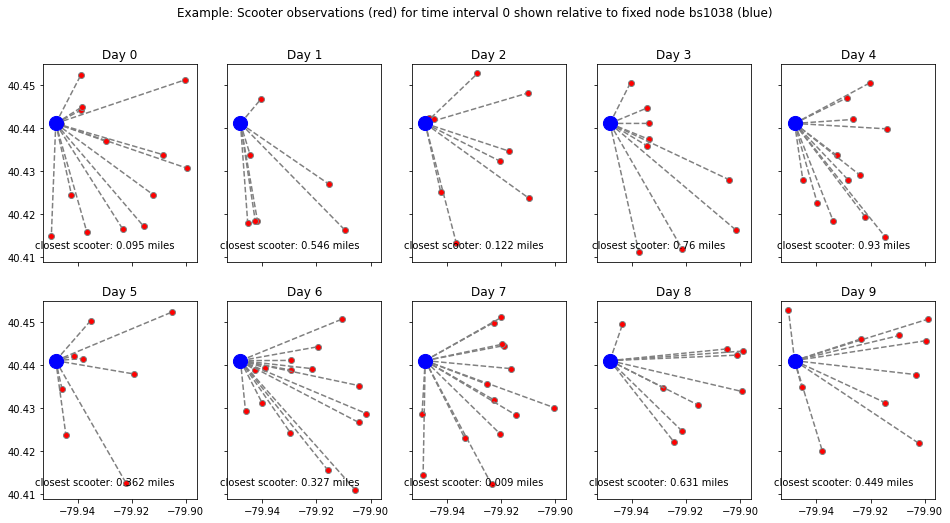

In [351]:
b1, b2 = 5, 0  # these are randomly selected, goal was to try to make scooter transfer cost in the range (2-5)
num_days_of_data = 10
num_obs_LB, num_obs_UB = 6, 16
sc_costs = gen_data(G_u, num_days_of_data, num_intervals, num_obs_LB, num_obs_UB, 
                    bbox_nhoods['minx'], bbox_nhoods['maxx'], bbox_nhoods['miny'], bbox_nhoods['maxy'],
                    nid_map_fixed, b1, b2, speed_params['w'])

In [352]:
speed_params['w']
sc_costs['bs1037']
# recall that cost_i for fixed node j is the average distance from node j to the NEAREST scooter for the past 10 days
# i.e. average min distance 
# we can use the example figure above and take the average of all the closest scooter distances. should match cost0

1

{'cost0': 2.1151754336189237,
 'cost1': 1.917010793783792,
 'cost2': 2.962185873325037,
 'cost3': 3.9048816946126292,
 'cost4': 2.2738834595008606,
 'cost5': 2.147352033640286,
 'cost6': 4.267298397659919,
 'cost7': 2.052490818663364,
 'cost8': 2.537699756051217,
 'cost9': 2.938673280397536}

## Step 3. Build Transfer Edges

In [353]:
# parameters
modes = ['bs', 'ps', 't', 'k', 'pb', 'sc'] # all modes
pmx = [('ps','ps'),('bs','ps'),('ps','bs'),('ps','t'),('t','ps'),('t','bs'),('bs','t'), # permitted mode change
       ('k','ps'),('k','t'),('k','bs'),('ps','pb'),('pb','ps'),('ps','sc'),('sc','ps'),('k','sc'),
       ('bs','sc'), ('sc','bs')]     

In [354]:
# returns walking catchment node for the node of interest
# inputs: nodeID of node interest, matrix of gc distances b/w all nodes, and max walking distance
# output: list of nodeIDs of all nodes within the wcz
def wcz(i, dist_matrix, W):
    catchment = np.where(dist_matrix[i] <= W)[0].tolist()
    if i in catchment:
        catchment.remove(i)  # remove self
    return catchment

In [355]:
# inputs: node of interest, matrix of gcd distances b/w all nodes, travel mode of interest, all nodes in the original graph (id+name)
# output: nodeID of the node in the component network of the travel mode of interest that is nearest to the input node of interest
def nn(i, dist_matrix, travel_mode, node_id_map):
    # subset the node_id_map for the nodes in the component network of the travel mode of interest
    nid_map_travel_mode = [key for key,val in node_id_map.items() if val.startswith(travel_mode)]   # this is a list of IDs
    # subset dist matrix for the nodes in the component network of the travel mode of interest
    dist_subset = dist_matrix[:, nid_map_travel_mode]
    # find the node in the component network of interest that is nearest to the input node of interest
    nn_dist = np.amin(dist_subset[i])
    nn_idx = np.argmin(dist_subset[i])
    # now map back to the original node ID
    original_nn_id = nid_map_travel_mode[nn_idx]
    original_nn_name = node_id_map[original_nn_id]
    return (original_nn_id, original_nn_name, nn_dist)

In [356]:
# issue: we are allowing parking -- personal vehicle transfer
# figure out where that is being added 
flex_pre

['t', 'sc', 'pv']

In [357]:
# now create transfer edges.
# TO DO: wrap this in a function
W = 0.5  # max walking distance [miles]
inc_cost = 80  # needs to be more carefully considered; arbitrary number to discourage transfers
etype = 'transfer'
trans_edges = {}

for i in list(nid_map_fixed.keys()):
    attrs = {}
    i_name = nid_map[i]  # map back to node name
    catch = wcz(i, gcd_dist, W)  # catchment zone around i (includes both fixed and flex nodes)
    # build transfer edge for each *fixed* node in the catchment zone 
    for j in catch:
        if j in nid_map_fixed.keys():
            j_name = nid_map[j]  # map back to node name
            if (mode(i_name), mode(j_name)) in pmx:         # if mode switch allowed between i and j
                # build the transfer edge
                edge = (i_name, j_name)
                # find the walking time associated with transfer edge, call it walk_cost
                walk_cost = gcd_dist[i,j] / speed_params['w']
                # also add an inconvenience cost; this needs to be more carefully considered. make sufficiently large for now
                base_cost = round(walk_cost + inc_cost, 4)
                
                #trans_edges[edge] = {'cost': base_cost, 'type': etype} # store the edge with associated attributes
                
                # add an edge attribute for num_intervals different costs to match the num_intervals time-dependent traversal edge costs
                # but the transfer edge cost is constant for all times 
                attr_dict = dict(zip(cost_keys, [base_cost]*num_intervals))  # holds costs attributes
                attr_dict['type'] = etype    # store edge type
                trans_edges[edge] = attr_dict
    
    # find the nearest neighbor in each flex network
    # but first, remove 'pv' nodes to prevent arbitary transfers to the pv network
    # 'pv' nodes are considered flexible for the sake of OD connectors 
    if 'pv' in flex_pre: 
        flex_pre_tx = flex_pre.copy()
        flex_pre_tx.remove('pv')
        
    for m in flex_pre_tx:    # transfers from fixed-flex or flex-fixed
        if (mode(i_name), m) in pmx:    # if mode switch allowed between i and m
            nnID, nnName, nnDist = nn(i, gcd_dist, m, nid_map)  # tuple in the form of (node_id, node_name, dist)
            if nnID in catch:   #and (m != 'sc')):
                k_name = nnName
                edge_in = (i_name, k_name)                
                edge_out = (k_name, i_name)
                walk_cost = nnDist / speed_params['w']                
                
                if m != 'sc':
                    base_cost = round(walk_cost + inc_cost, 4)  # includes inconvenience cost
        
                    #trans_edges[edge_in] = {'cost': base_cost, 'type': etype} # store the edge with associated attributes
                    #trans_edges[edge_out] = {'cost': base_cost, 'type': etype}  # store the edge with associated attributes
                    # add an edge attribute for 5 different costs to match the 5 time-dependent traversal edge costs
                    # but the transfer edge cost is constant for all times 
                    
                    attr_dict = dict(zip(cost_keys, [base_cost]*num_intervals))  # holds costs attributes
                    attr_dict['type'] = etype    # store edge type
                    trans_edges[edge_in] = attr_dict
                    if (mode(k_name), mode(i_name)) in pmx:  # prevents (tnc-parking) transfers. see commentary below
                        trans_edges[edge_out] = attr_dict  
                    
                else:  # mode is scooter
                    # when transferring TO scooter, assign costs that were created above according to historical data
                    attr_dict = sc_costs[i_name]
                    attr_dict =  {key: (val + inc_cost) for key, val in attr_dict.items()}  # add inconvenience cost to the cost of walking to scooter
                    attr_dict['type'] = etype
                    trans_edges[edge_in] = attr_dict
                    
                    # when transferring FROM scooter, use nearest neighbor distance b/c ride scooter to closest pickup point for next mode
                    if (mode(k_name), mode(i_name)) in pmx:   
                        attr_dict = dict(zip(cost_keys, [round(walk_cost + inc_cost, 4)]*num_intervals))
                        attr_dict['type'] = etype
                        trans_edges[edge_out] = attr_dict        

Initially the transfer edge procedure returned transfers from TNC to parking. This makes sense for the return trip, but not the outbound trip. Thus we modified the tranfer edge code.

In [358]:
# test that the transfers make sense
for edge in trans_edges.keys():
    # find the great circle dist between the nodes
    nid_0 = inv_nid_map[edge[0]]
    nid_1 = inv_nid_map[edge[1]]
    gcd = gcd_dist[nid_0, nid_1]
    if gcd > 0.5:
        print(edge[0], edge[1], gcd)   # no results, which means all transfer are to nodes within WCZ (as expected)
    if (mode(edge[0]), mode(edge[1])) not in pmx:   # no results, as expected
        print(edge) 
         # initially returned transfers from TNC to parking. this makes sense for the return trip, but not the outbound trip
         # thus we will modify the tranfer edge code
    if (mode(edge[0]), mode(edge[1])) == ('k', 'pv'):
        print(edge)

In [359]:
# need to add link ids for transfer edges
for attr_dict in trans_edges.values():
    attr_dict['link_ID'] = prev_max_linkID + 1
    prev_max_linkID += 1

In [360]:
#trans_edges

In [361]:
# add transfer edges and their attributes
G_u.add_edges_from(list(trans_edges.keys()))  # real graph
nx.set_edge_attributes(G_u, trans_edges) # attributes

G_u_adj.add_edges_from(list(trans_edges.keys()))  # adj graph (for drawing purposes)
nx.set_edge_attributes(G_u_adj, trans_edges)  # attributes 

## ODs and OD connectors

### Draw the graphs including transfer edges

In [362]:
# edge_cmap = ['silver' if edge_type == 'traversal' else 'gold' for edge, edge_type in nx.get_edge_attributes(G_u_adj,'type').items()]
# node_color = node_color_list(G_u_adj)
# ax = draw_graph(G_u_adj, node_color, node_cmap, edge_cmap)
# ax.set_title('Supernetwork, where phsyically overlapping networks are offset, with transfer edges', fontsize=16)

## Shortest Path

### Single Shortest Path Example

In [363]:
def sp_string(sp_edges):
    s = ''
    for i, e in enumerate(sp_edges):
        s = s + ' ' + e[0]
        
        if i == len(sp_edges) - 1:  
            s = s + ' ' + e[1]
#             s = s + ' ' + 'dst'   # RE-ADD THIS WHEN WE INCLUDE OD CONNECTORS
    return(s)

In [364]:
# find total cost of shortest weighted path
# input: graph, edges of shortest path, attribute used as weight
# output: total cost of shortest path
def sp_total_cost(G, sp_edges, weight):
    total_cost = 0
    edge_costs = []
    for e in sp_edges:
        edge_costs.append(G.edges[e][weight])
        total_cost += G.edges[e][weight]
    print('Total cost of the shortest path from org to dst = ', round(total_cost,2))  
    print(edge_costs)
    #return(total_cost, edge_costs)

rt20048_65_1 ps10948


Text(0.5, 1.0, 'Shortest Path between Org and Dst \n rt20048_65_1 ps20048 rt20048_74_1 rt8009_74_1 rt21095_74_1 ps21095 ps10948')

Total cost of the shortest path from org to dst =  147.24
[3, 3, 29.994992802211705, 27.75449364542739, 3, 80.4877]


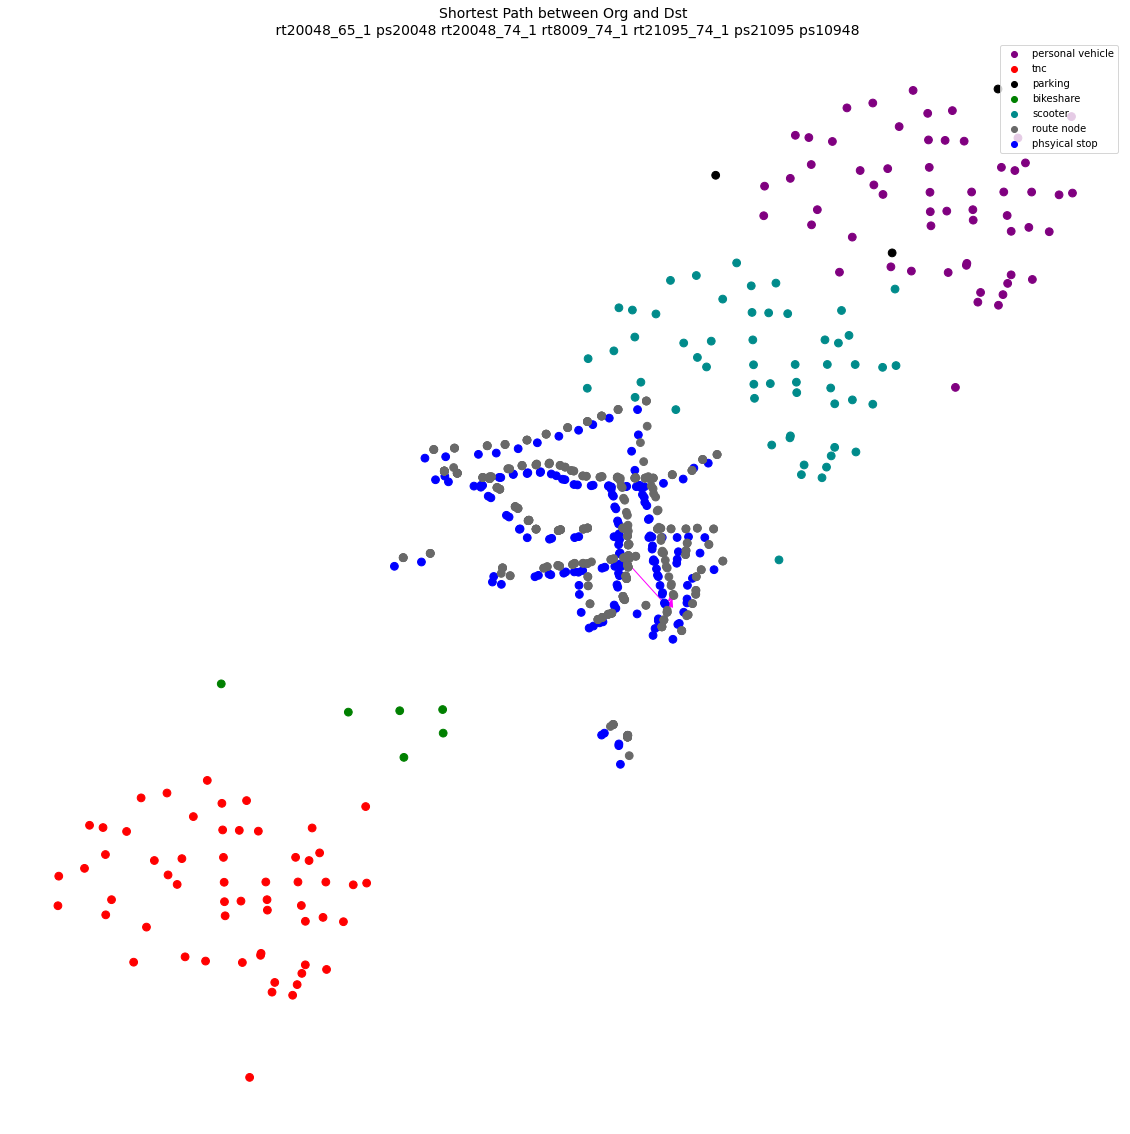

In [369]:
# select random ODs for testing
org = nid_map[floor(np.random.uniform(0, len(G_u.nodes)))]
while True:
    dst = nid_map[floor(np.random.uniform(0, len(G_u.nodes)))]
    if mode(dst) != 'pv':  # right now there is no way to get back to PV network, so generate another destination for testing
        break
print(org,dst)

# interesting org/dst: rt8019/pv7787
weight = 'cost2'
sp = nx.dijkstra_path(G_u, org, dst, weight)
sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)] 
#print(sp_edges)
G_sp = G_u_adj.copy()
G_sp.remove_edges_from(list(G_u_adj.edges))
G_sp.add_edges_from(sp_edges)
ax = draw_graph(G_sp, node_color, node_cmap, 'magenta')
ax.set_title('Shortest Path between Org and Dst \n' + sp_string(sp_edges), fontsize = 14)
sp_total_cost(G_u, sp_edges, weight)

In [337]:
trans_edges

{('bs1037', 'ps8021'): {'cost0': 80.4405,
  'cost1': 80.4405,
  'cost2': 80.4405,
  'cost3': 80.4405,
  'cost4': 80.4405,
  'cost5': 80.4405,
  'cost6': 80.4405,
  'cost7': 80.4405,
  'cost8': 80.4405,
  'cost9': 80.4405,
  'type': 'transfer',
  'link_ID': 76477},
 ('bs1037', 'ps17527'): {'cost0': 80.4295,
  'cost1': 80.4295,
  'cost2': 80.4295,
  'cost3': 80.4295,
  'cost4': 80.4295,
  'cost5': 80.4295,
  'cost6': 80.4295,
  'cost7': 80.4295,
  'cost8': 80.4295,
  'cost9': 80.4295,
  'type': 'transfer',
  'link_ID': 76478},
 ('bs1037', 'ps7117'): {'cost0': 80.384,
  'cost1': 80.384,
  'cost2': 80.384,
  'cost3': 80.384,
  'cost4': 80.384,
  'cost5': 80.384,
  'cost6': 80.384,
  'cost7': 80.384,
  'cost8': 80.384,
  'cost9': 80.384,
  'type': 'transfer',
  'link_ID': 76479},
 ('bs1037', 'ps7119'): {'cost0': 80.4974,
  'cost1': 80.4974,
  'cost2': 80.4974,
  'cost3': 80.4974,
  'cost4': 80.4974,
  'cost5': 80.4974,
  'cost6': 80.4974,
  'cost7': 80.4974,
  'cost8': 80.4974,
  'cost9': 8

**TO DO:** <br>
1. **COMPLETE** Consolidate bikeshare graph by precomputation
    1. **COMPLETE** Dependency: Add FIFO random edge cost function, then run shortest path
1. **COMPLETE** Add public tranit unimodal graph
1. **COMPLETE** Add scooter unimodal graph
1. **COMPLETE** Construct supernetwork
1. **COMPLETE** Visualize plain supernetwork as well as offset supernetwork (where individual network nodes are slightly offset)
1. **COMPLETE** Add random time-dependent edge costs (first-in-first-out random edge cost function)
1. **COMPLETE** Generate fake historical scooter location data
1. **COMPLETE** Once all unimodal networks are included, add transfer edges
1. Add OD connector edges
1. **COMPLETE** Draw an "edge-less" graph i.e. G_u_adj but only nodes. Then superimpose the shortest path edges
1. **COMPLETE** Run single shortest path
1. Run time-depdendent shortest path
1. Right now, it is not possible to transfer from TNC to scooter. We can make this possible by adding a transfer edge from every node in the TNC network to its nearest neighbor in the scooter network, and assign costs using the historical data procedure that was used for fixed nodes. Decide if this makes sense
1. Something is missing in the PT network. Right now there is a single route edge that may represent many routes, say 61A, 61B, 61C, 61D. Moreover, there are no transfer edges between routes.
    1. Solution: for each physical stop, create as many route nodes as there are route lines